# TERRA Colocolizes to Double Stranded Breaks (DSBs), esp. in G2
This project is the data analysis of Dr. Taghreed Mohammed Al Turki's PhD data, in continuation of Chris Nelson's(?) previous work. The objective is to eelucidate if TERRA locolizes to global DSBs, to telomeric DSB's, and which phase of the cell cycle does TERRA colocolize to telo DSBs. 

In [1]:
# handling data
import pandas as pd
import numpy as np

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value Stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

print("Setup Complete")

Setup Complete


In [2]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


# Setting up the data

We want the data to be read by the program environment so that we can run quick and accurate analysis further on.

In [3]:
### REMEBER TO SAVE AS CSV FOR GITHUB ###

#Data for Global DSB analyis
global_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['Distribution of TERRA Foci/Cell', 'Cell Condition']
                              )

global_df.set_index(['Distribution of TERRA Foci/Cell'])
global_df.dropna(axis=0, inplace=True) 

#global_df.columns
global_df.head()

,Distribution of TERRA Foci/Cell,Cell Condition
0,14,2Gy
1,24,2Gy
2,19,2Gy
3,43,2Gy
4,17,2Gy


In [4]:
### REMEBER TO SAVE AS CSV FOR GITHUB ###

#Data for Global DSB analyis
global_pivot_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=0,
                    skiprows = 0,
                    #usecols = ['Distribution of TERRA Foci/Cell', 'Cell Condition']
                              )

global_pivot_df.set_index(['2Gy'])
global_pivot_df.dropna(axis=0, inplace=True) 

#global_pivot_df.columns
global_pivot_df.head()

,2Gy,0Gy,2Gy & RNAseA+H,0Gy & RNAseA+H
0,14,2,1.0,8
1,24,2,0.0,5
2,19,1,3.0,5
3,43,0,1.0,8
4,17,11,1.0,6


In [5]:
#Data for telo DSB analyis
telo_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=6,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Colocolization','Number of Foci','Foci per Cell'
                               
                              ] 
                         )

telo_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
telo_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_df.columns()
telo_df.head()

,Cell_condition,Colocolization,Number of Foci,Foci per Cell
0,EN-T,FLAG v. TERRA,689.5,25.072727
1,TRF1,FLAG v. TERRA,651.5,21.716667
2,Empty,FLAG v. TERRA,9.5,0.904762
3,Untransfected,FLAG v. TERRA,0.0,0.000000
4,EN-T & RNAseA+H,FLAG v. TERRA,480.5,24.641026


In [6]:
#Data for telo DSB analyis
telo_coloc_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=7,
                    skiprows = 0,
                    usecols = ['Cell Condition', 'FLAG v. TERRA','FLAG v. TRF2 v. TERRA','TRF2 v. TERRA'
                               
                              ] 
                         )

telo_coloc_df.set_index(['Cell Condition'])#good way to fix "not in axis issue"
telo_coloc_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_coloc_df.columns()
telo_coloc_df.head()

,Cell Condition,FLAG v. TERRA,FLAG v. TRF2 v. TERRA,TRF2 v. TERRA
0,Empty,0.904762,1.857143,10.476190
1,Empty,13.095238,2.333333,12.761905
2,Empty,8.697674,2.837209,15.860465
3,Empty,8.916667,3.777778,17.194444
4,Empty,7.457143,1.942857,12.342857


In [7]:
#Data for telo DSB analyis
telo_cell_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=8,
                    skiprows = 0,
                    usecols = ['Colocolization', 'EN-T','TRF1','Empty','Untransfected','EN-T & RNAseA+H',
                               'TRF1 & RNAseA+H','Empty & RNAseA+H','Untransfected & RNAseA+H'   
                              ] 
                         )

telo_cell_df.set_index(['Colocolization'])#good way to fix "not in axis issue"
telo_cell_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_cell_df.columns()
telo_cell_df.head()

,Colocolization,EN-T,TRF1,Empty,Untransfected,EN-T & RNAseA+H,TRF1 & RNAseA+H,Empty & RNAseA+H,Untransfected & RNAseA+H
0,FLAG v. TERRA,25.072727,21.716667,0.904762,0.000000,24.641026,11.380952,7.500000,0.0
1,FLAG v. TERRA,39.486486,32.428571,13.095238,0.000000,18.000000,29.051724,12.631579,0.0
2,FLAG v. TERRA,36.553191,35.602564,8.697674,0.000000,26.000000,26.741935,20.509091,0.0
3,FLAG v. TERRA,44.680851,42.129870,8.916667,8.666667,30.640000,39.086957,4.642857,0.0
4,FLAG v. TERRA,32.786885,37.803279,7.457143,0.000000,15.264706,18.382979,8.228571,0.0


In [8]:
telo_drop_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=9,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Colocolization','Number of Foci','Foci per Cell'
                               
                              ] 
                         )

telo_drop_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
telo_drop_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_drop_df.columns()
telo_drop_df.head(82)

,Cell_condition,Colocolization,Number of Foci,Foci per Cell
0,EN-T,FLAG v. TERRA,689.5,25.072727
1,TRF1,FLAG v. TERRA,651.5,21.716667
2,Empty,FLAG v. TERRA,9.5,0.904762
3,Untransfected,FLAG v. TERRA,0.0,0.000000
4,EN-T & RNAseA+H,FLAG v. TERRA,480.5,24.641026
...,...,...,...,...
77,TRF1 & RNAseA+H,FLAG v. TERRA,461.5,4.807292
78,Empty & RNAseA+H,FLAG v. TERRA,69.5,2.474453
79,Untransfected & RNAseA+H,FLAG v. TERRA,3.0,0.031088
80,EN-T,TRF2 v. TERRA,5.0,0.181818


In [9]:
# To look at the relationship betweeen cell accumulation and TERRA accumulation per phase
g2_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=6,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Phase','TERRA Amount','Cell Amount',
                               'TERRA % In Phase','Cell % In Phase'] 
                         )

g2_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
g2_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_df.columns()
g2_df.head(6)

,Cell_condition,Phase,TERRA Amount,TERRA % In Phase,Cell Amount,Cell % In Phase
0,Empty,G1,132.0,10.806386,9.0,11.920530
1,Empty,G1,346.5,23.467660,16.5,24.812030
2,Empty,G1,814.0,41.267427,50.5,49.029126
3,Empty,G1,437.0,20.349243,21.0,21.761658
4,Empty,G1,264.0,13.618777,16.0,17.391304
5,Empty,S,65.0,5.321326,2.0,2.649007


In [80]:
# To look at the relationship betweeen cell accumulation and TERRA accumulation per phase
g2_tukey_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=7,
                    skiprows = 0,
                    #usecols = ['Cell Transfection', 'Phase','TERRA Amount','Cell_Amount',
                               #'TERRA_%_In_Phase','Cell_%_In_Phase'] 
                         )

g2_tukey_df.set_index(['Cell Transfection'])#good way to fix "not in axis issue"
g2_tukey_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_tukey_df.columns()
g2_tukey_df.head(6)

,Cell Transfection,G1 Cell,S Cell,G2 Cell,G1 TERRA,S TERRA,G2 TERRA
0,Empty,9.0,2.0,64.5,132.0,65.0,1024.5
1,Empty,16.5,10.5,39.5,346.5,245.5,884.5
2,Empty,50.5,3.5,49.0,814.0,76.5,1082.0
3,Empty,21.0,12.0,63.5,437.0,380.5,1330.0
4,Empty,16.0,6.0,70.0,264.0,152.5,1522.0
5,Empty & RNAseA+H,42.0,29.5,4.0,90.0,38.5,6.5


# TERRA Responds to Global DSBs
   - What the experiment is (e.g. what is it testing and how):
   - "To induce Global DSBs, U2OS cells were treated with 2 gy Gamma rays, recovered for 4 hours, fixed." 
   - "To evaluate the induction of TERRA in response to the Global DSBs, the fixed cells were stained with C-rich labeld PNA probe. The experiment was repeated and cells were treated with a cocktail of  Rnase H and A for the removal of TERRA foci (negative control)." 


## Bar Plot

[None, None, None, None, None, None, None, None]

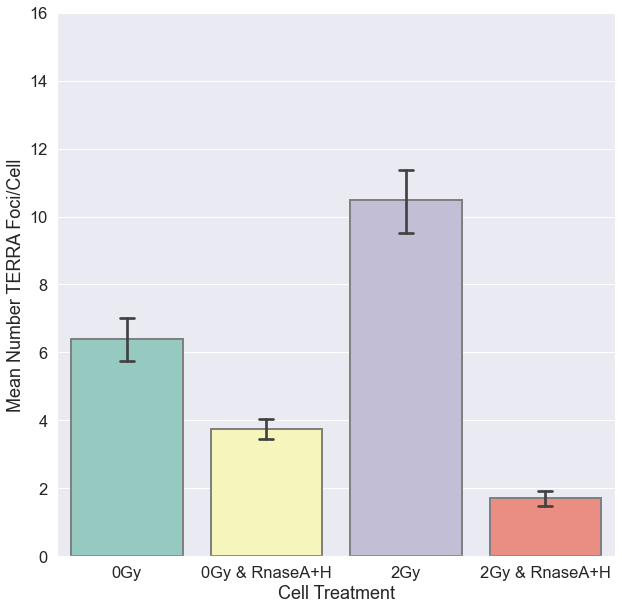

In [10]:
# Bar plot that uses all the values so we can get varience/stats measures
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
ax = sns.barplot(x=global_df['Cell Condition'],y='Distribution of TERRA Foci/Cell',
                 data=global_df,  palette="Set3", order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H'],
                 capsize=0.1, ci=68,
                )

ax.set(ylim=(0,16), xlabel='Cell Treatment', ylabel = 'Mean Number TERRA Foci/Cell' )

#plt.title('Mean TERRA Foci/Cell Based On Treatment')
plt.setp(ax.patches, linewidth=2, edgecolor=".5")

#plt.savefig(f'global_terra_bar.png', dpi=900, bbox_inches='tight')

## Stats

In [11]:
# one-way ANOVA's 

#Between all the groups
all_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['0Gy & RNAseA+H'],
               global_pivot_df['2Gy'],
               global_pivot_df['2Gy & RNAseA+H'])

#Between 0Gy and 2Gy
Zv2_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['2Gy'],
                )

#Between 0Gy and 0Gy & RNAseA+H
ZvZR_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['0Gy & RNAseA+H'],
               )

#Between 2Gy and 2Gy & RNAseA+H
Gy2v2R_global_anova = stats.f_oneway(global_pivot_df['2Gy'],
               global_pivot_df['2Gy & RNAseA+H'])

print( all_global_anova,'Between All\n',
       Zv2_global_anova,'0Gy vs. 2Gy\n',
       ZvZR_global_anova, '0Gy vs. 0Gy + Rnase\n',
       Gy2v2R_global_anova, '2Gy vs. 2Gy + Rnase\n'
     )

# All p<<0 indicates statistical significant difference between all the groups ****
# 0Gy vs. 2Gy P = 0.00042 indicates difference ***
# 0Gy vs. 0Gy + Rnase P=0.00027 indicates difference ***
# 2Gy vs. 2Gy + Rnase P=<<0 indicates difference ****

F_onewayResult(statistic=40.22130919965053, pvalue=3.673096649706062e-23) Between All
 F_onewayResult(statistic=12.807020720648879, pvalue=0.0004190395594394681) 0Gy vs. 2Gy
 F_onewayResult(statistic=13.687831185821716, pvalue=0.00026860018343309675) 0Gy vs. 0Gy + Rnase
 F_onewayResult(statistic=84.44535425121381, pvalue=2.1100880702536034e-17) 2Gy vs. 2Gy + Rnase



In [12]:
# perform Tukey HSD to confirm ANOVA results
global_tukey = pairwise_tukeyhsd(endog=global_df['Distribution of TERRA Foci/Cell'],
                          groups=global_df['Cell Condition'],
                          alpha=0.05)

print(global_tukey)

#Tukey HSD confirms the differences and includes that the +RNAse groups are not stat. different

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
           0Gy 0Gy & RnaseA+H    -2.65 0.0085  -4.7985 -0.5015   True
           0Gy            2Gy   4.0667  0.001   1.9182  6.2152   True
           0Gy 2Gy & RnaseA+H     -4.7  0.001  -6.8485 -2.5515   True
0Gy & RnaseA+H            2Gy   6.7167  0.001   4.5682  8.8652   True
0Gy & RnaseA+H 2Gy & RnaseA+H    -2.05 0.0678  -4.1985  0.0985  False
           2Gy 2Gy & RnaseA+H  -8.7667  0.001 -10.9152 -6.6182   True
---------------------------------------------------------------------


## Box Plot

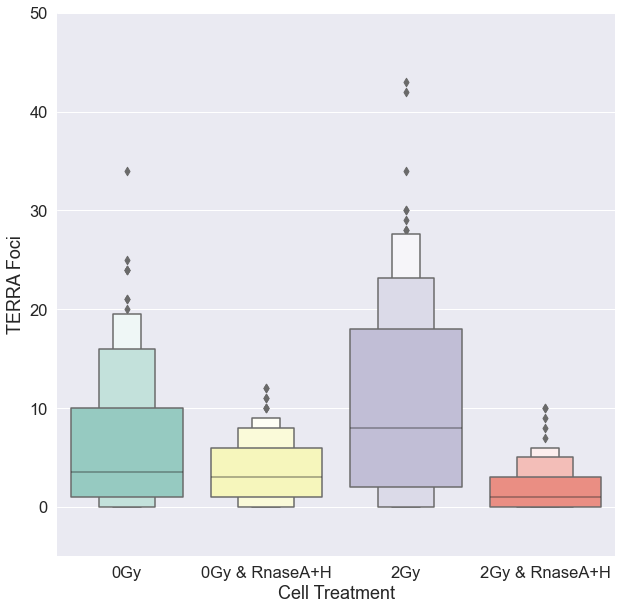

In [13]:
# A better representation of the distribution
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
ax = sns.boxenplot(x=global_df['Cell Condition'],  palette="Set3", y='Distribution of TERRA Foci/Cell',
                 data=global_df, order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H'])

ax.set(ylim=(-5, 50), xlabel= "Cell Treatment", ylabel="TERRA Foci")
sns.despine(left=True, bottom=True)
#plt.title('Distributions of TERRA Foci Based on Treatment')

#plt.savefig(f'global_terra_box.png', dpi=900, bbox_inches='tight')

# TERRA Locolizes to Telomeric DSBs
  - What the experiment is (e.g. what is it testing and how):
  - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
  - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
    - a.FLAG  ( to label the positvely transfected cells).
    - b. yH2AX ( DSBs marker)
    - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
    - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).


## Bar Plots

### Without Tricolocolization
We decided to remove the tricolocolizations because there was a technical issue with some cells seeing all three combined

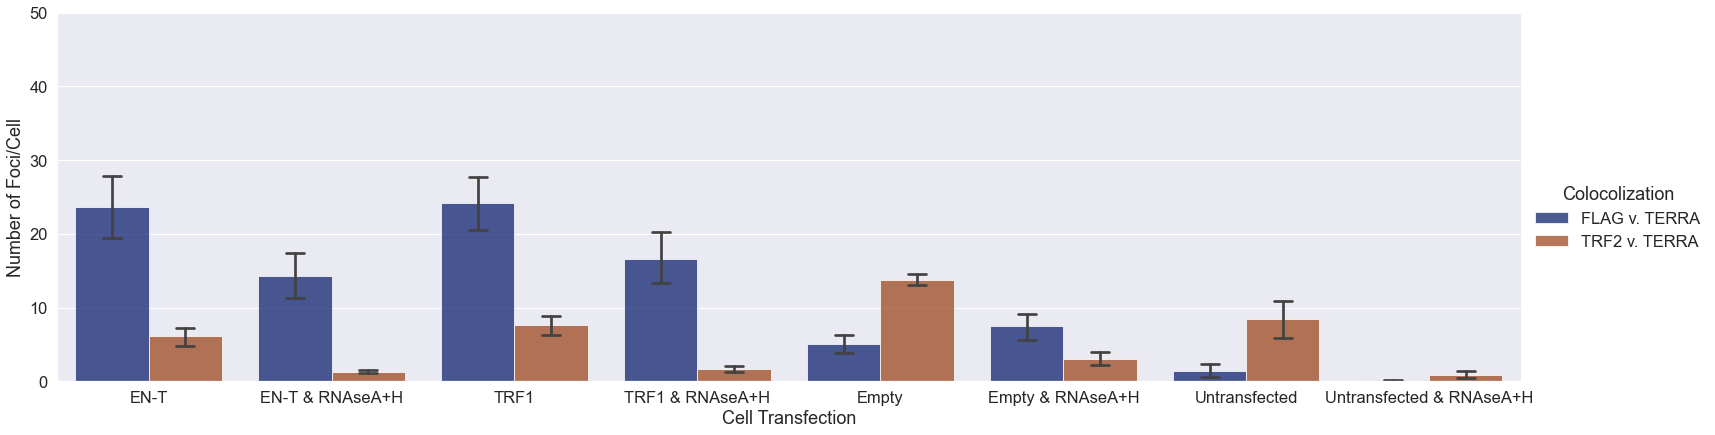

In [14]:
# Catagorical bar plot with all the colocolizations
#plt.figure(figsize=(9,6))
#sns.set(rc={'figure.figsize':(20,10)})
#sns.set(font_scale=3)
g = sns.catplot(
    data=telo_drop_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization", 
    palette="dark", alpha=.75, 
    height=6, aspect=3.55, 
    capsize=0.1, ci=68, order = ['EN-T', 
                                 'EN-T & RNAseA+H','TRF1',
                                 'TRF1 & RNAseA+H','Empty', 
                                 'Empty & RNAseA+H',
                                 'Untransfected', 
                                 'Untransfected & RNAseA+H']
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Number of Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,50))
#plt.title("Average Cololocolized Foci/Cell")
#g.set_xticklabels(rotation=30)

#plt.savefig(f'telo_drop1_whole.png', dpi=900, bbox_inches='tight')

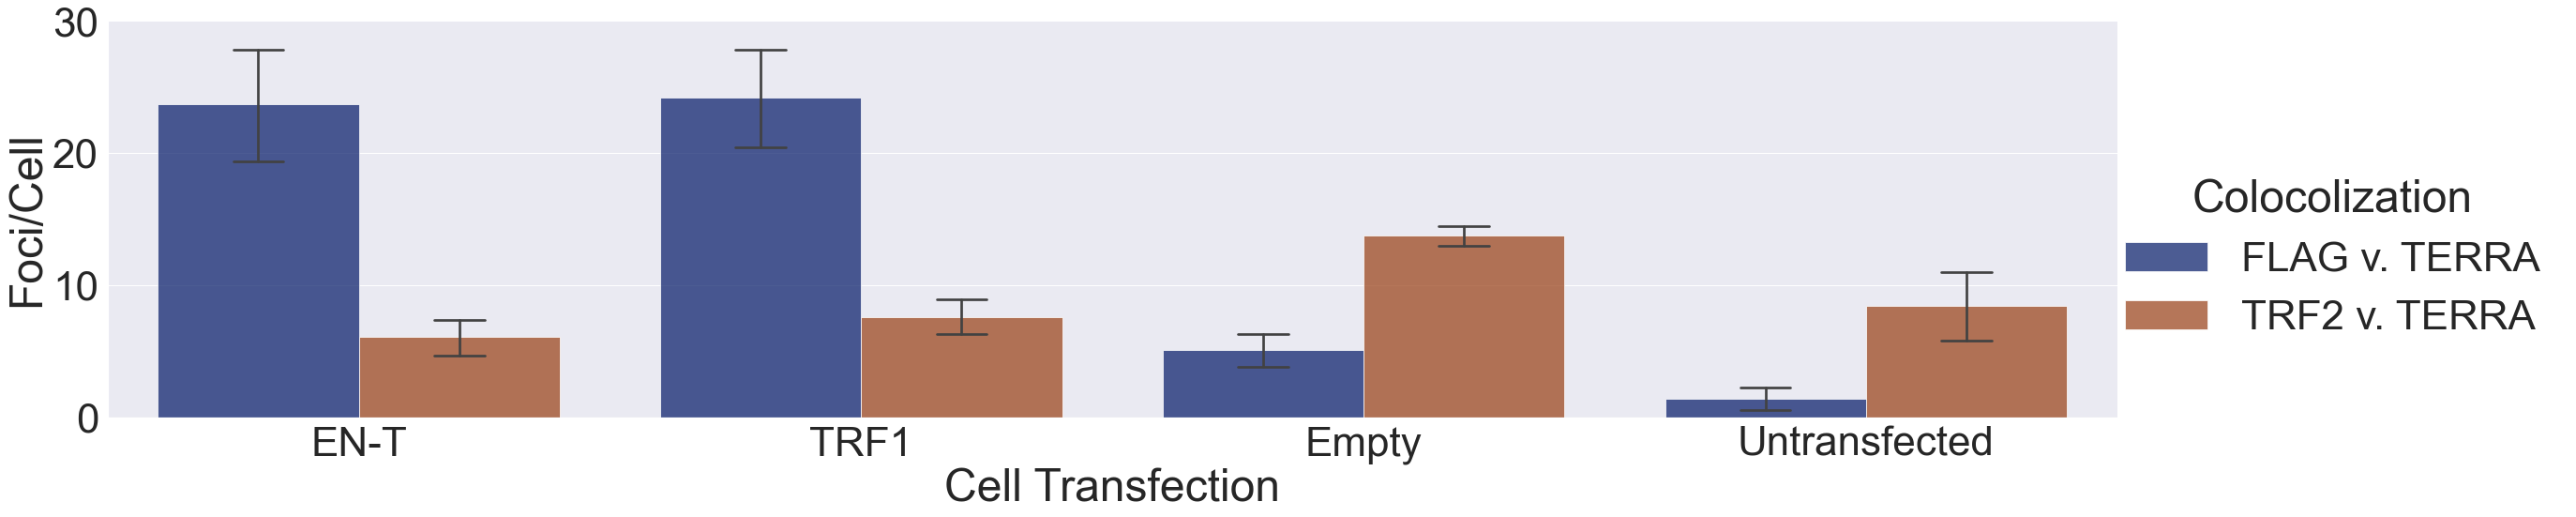

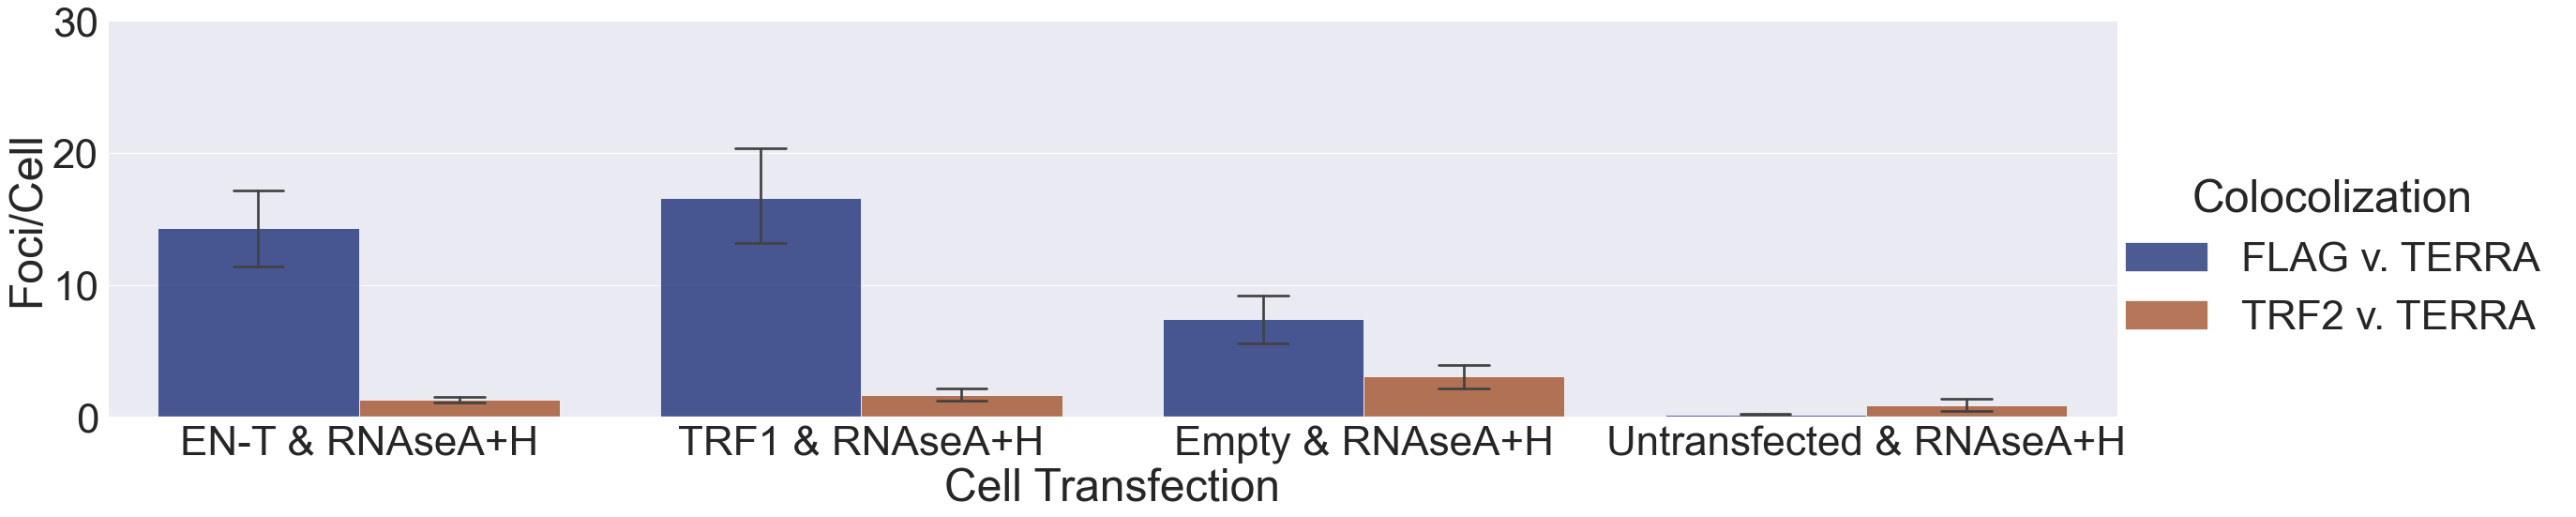

In [15]:
# Catagorical bar plot with all the non-rnase colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=telo_drop_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization", order = ['EN-T' 
                                                         ,#'EN-T & RNAseA+H',
                                                           'TRF1'
                                                         ,#'TRF1 & RNAseA+H',
                                                         'Empty'
                                                         ,#'Empty & RNAseA+H',
                                                            'Untransfected' 
                                                         ,#'Untransfected & RNAseA+H'
                                                        ],
    palette="dark", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68, 
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,30))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'telo_dropw-ornase_whole.png', dpi=900, bbox_inches='tight')

# Catagorical bar plot with all the +rnase colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=telo_drop_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization", order = [#'EN-T', 
                                                         'EN-T & RNAseA+H'
                                                           #,'TRF1'
                                                         ,'TRF1 & RNAseA+H'
                                                         #,'Empty'
                                                         ,'Empty & RNAseA+H'
                                                           #,'Untransfected' 
                                                         ,'Untransfected & RNAseA+H'
                                                        ],
    palette="dark", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,30))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'telo_dropw-rnase_whole.png', dpi=900, bbox_inches='tight')


### With Tricolocolization

<Figure size 720x720 with 0 Axes>

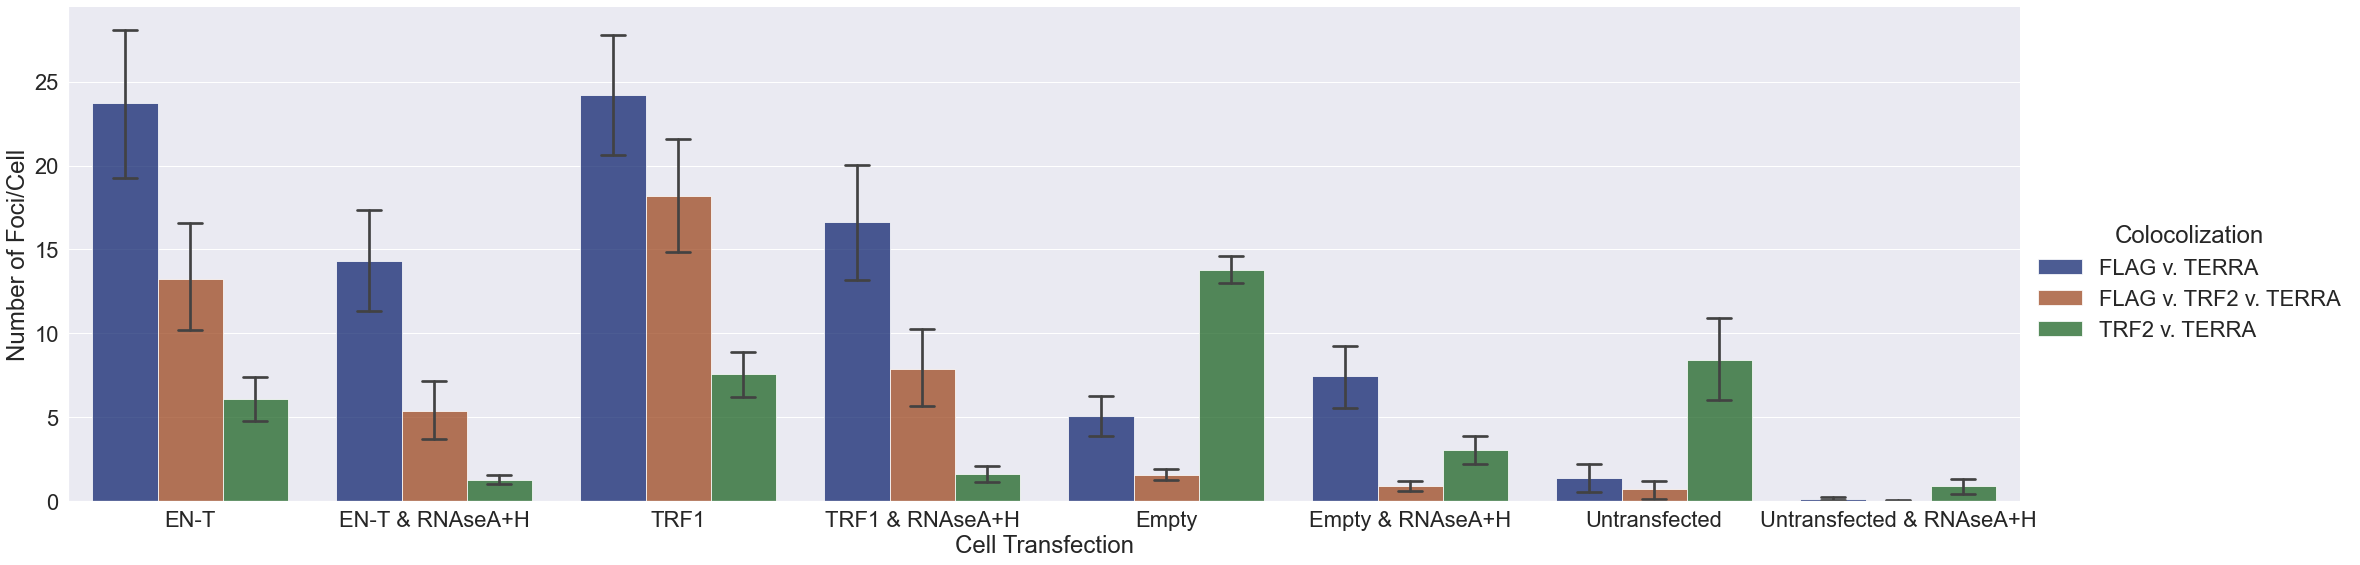

In [16]:
# Catagorical bar plot with all the colocolizations
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization",
    palette="dark", order = ['EN-T', 'EN-T & RNAseA+H','TRF1','TRF1 & RNAseA+H','Empty', 'Empty & RNAseA+H',
             'Untransfected', 'Untransfected & RNAseA+H'],
    alpha=.75, height=8, aspect=3.55,
    capsize=0.1, ci=68
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Number of Foci/Cell")
g.legend.set_title("Colocolization")
#plt.title("Average Cololocolized Foci/Cell")

#plt.savefig(f'telo_terra_whole.png', dpi=900, bbox_inches='tight')

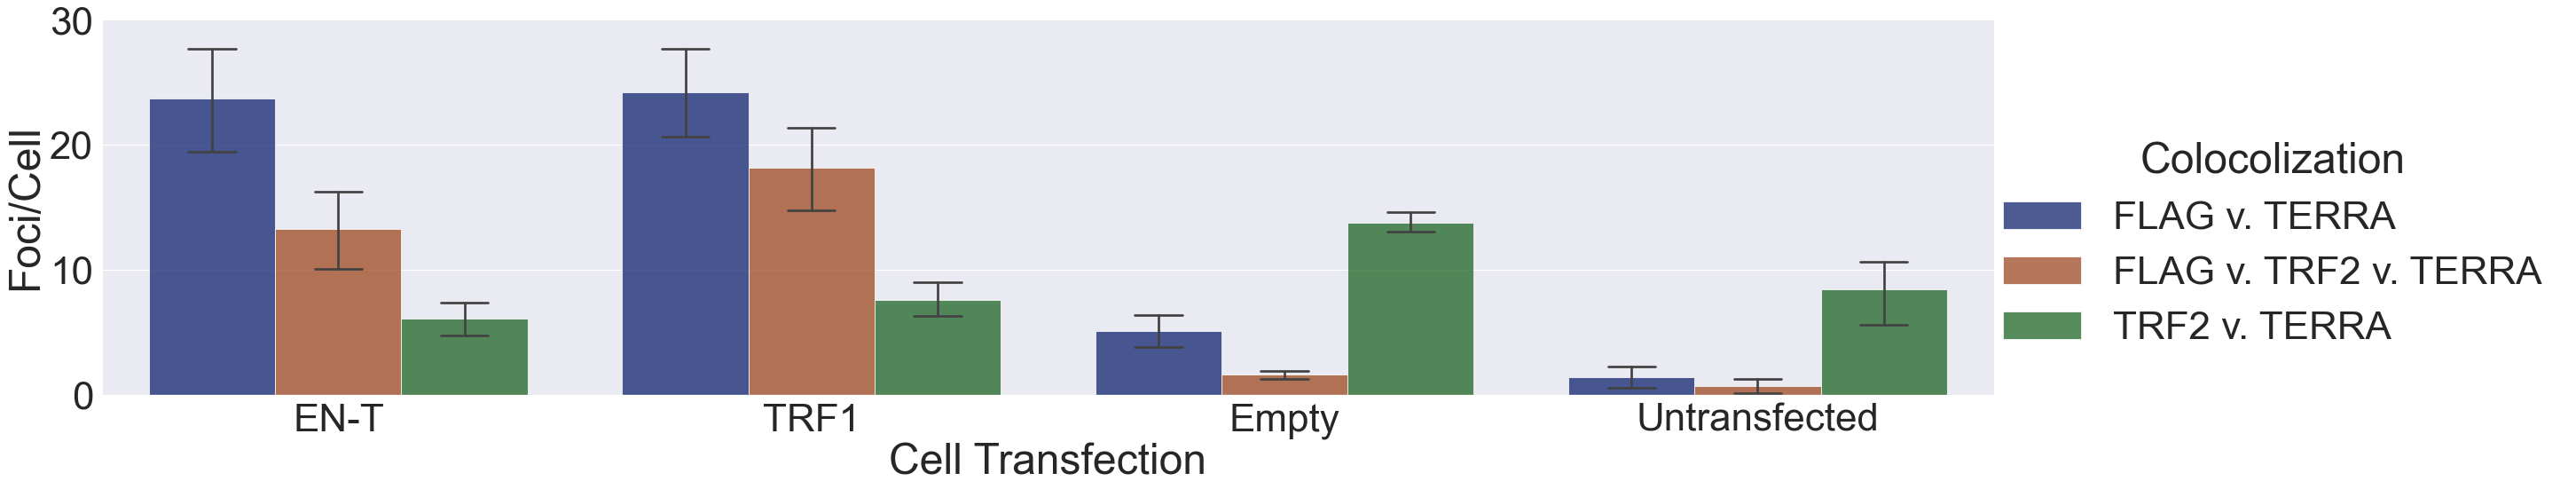

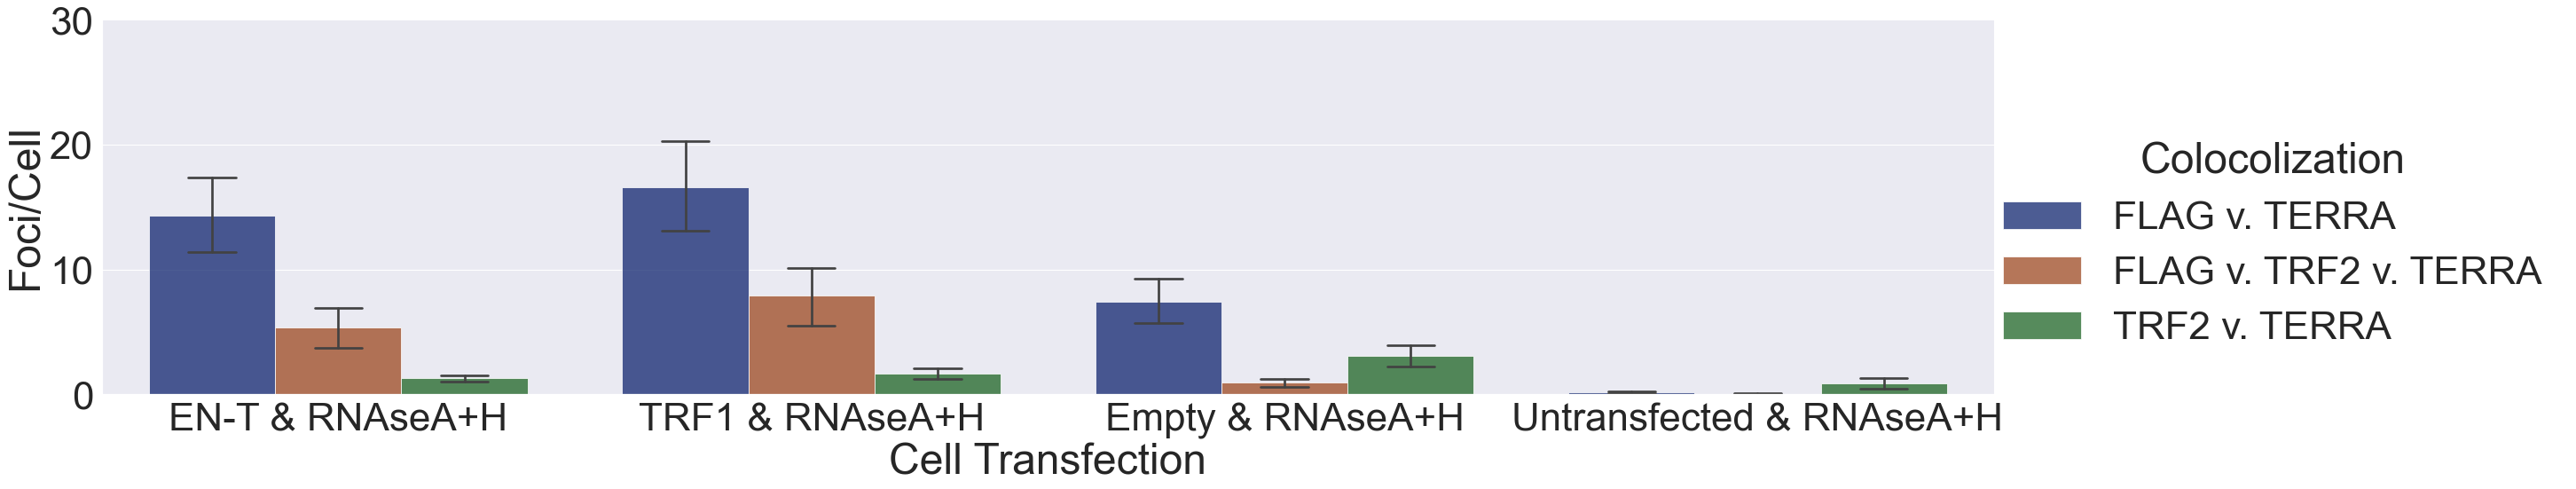

In [17]:
# Catagorical bar plot with all the non-rnase colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization", order = ['EN-T' 
                                                         ,#'EN-T & RNAseA+H',
                                                           'TRF1'
                                                         ,#'TRF1 & RNAseA+H',
                                                         'Empty'
                                                         ,#'Empty & RNAseA+H',
                                                            'Untransfected' 
                                                         ,#'Untransfected & RNAseA+H'
                                                        ],
    palette="dark", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68, 
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,30))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'telo_triw-ornase_whole.png', dpi=900, bbox_inches='tight')

# Catagorical bar plot with all the +rnase colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization", order = [#'EN-T', 
                                                         'EN-T & RNAseA+H'
                                                           #,'TRF1'
                                                         ,'TRF1 & RNAseA+H'
                                                         #,'Empty'
                                                         ,'Empty & RNAseA+H'
                                                           #,'Untransfected' 
                                                         ,'Untransfected & RNAseA+H'
                                                        ],
    palette="dark", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,30))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'telo_triw-rnase_whole.png', dpi=900, bbox_inches='tight')


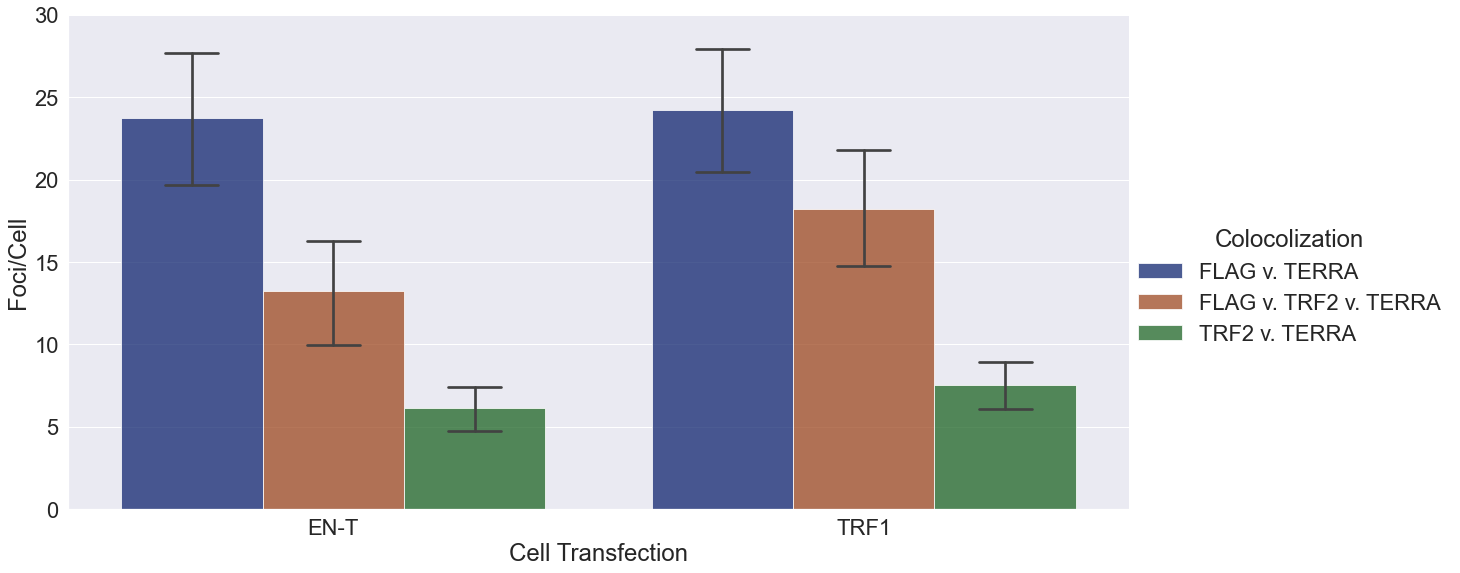

In [18]:
# Show that TERRA responds to DSB's from either EN-T and TRF1
ax = sns.set(font_scale=2)
#ax = plt.figure(figsize=(10,8))

g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8, aspect=2, order=["EN-T","TRF1"]
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,30))
#plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_ENTvTRF1.png', dpi=900, bbox_inches='tight')

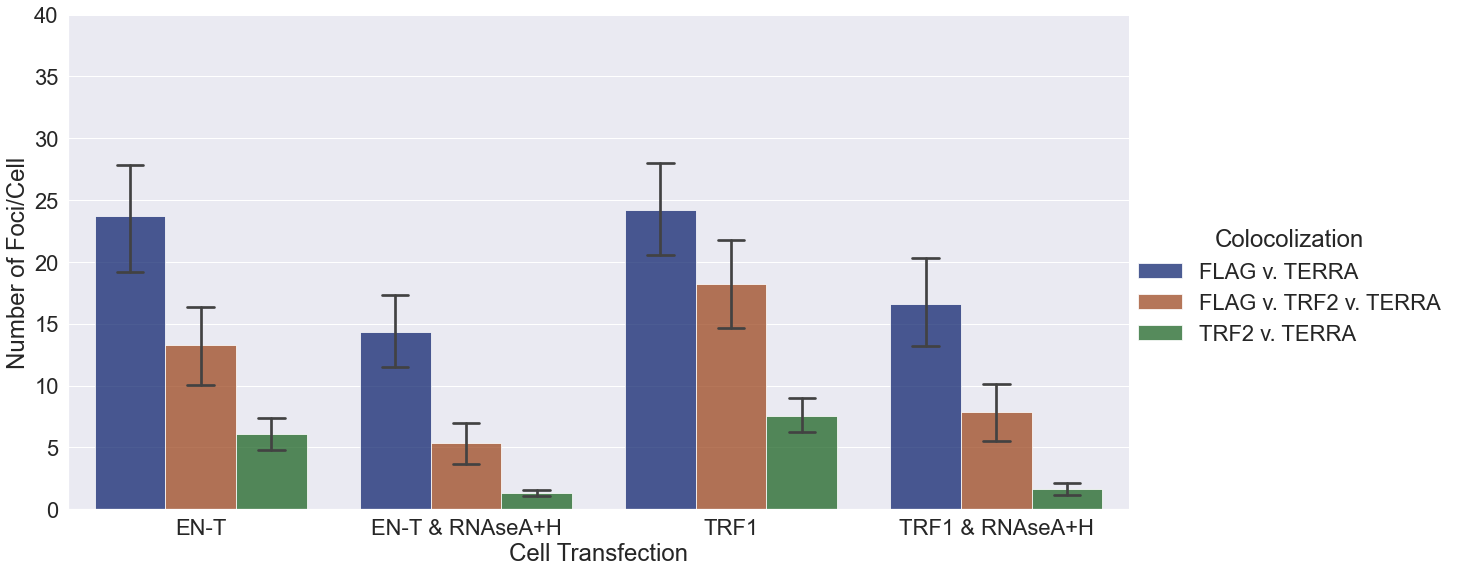

In [19]:
#Show that RNAseA+H reduces levels of TERRA, almost to scale which is intersting
ax = sns.set(font_scale=2)
#ax = plt.figure(figsize=(10,8))

g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8, aspect=2, 
    order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Number of Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,40))
#plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_EvTwRNAse.png', dpi=900, bbox_inches='tight') #cant use "/" in the name

In [20]:
# ANOVA between FLAG v. T of the ENT groups
d = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['EN-T & RNAseA+H'].iloc[:10],
                                 )

# ANOVA between tri coloc of the ENT groups
e =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['EN-T & RNAseA+H'].iloc[11:20],
                                 )

# ANOVA between TRF2 v. T of the ENT groups
f = stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['EN-T & RNAseA+H'].iloc[11:20],
                                 )

# ANOVA between FLAG v. T of the TRF1 groups
g = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[:10],
                                 )

# ANOVA between tri coloc of the TRF1 groups
h = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[11:20],
                                 )

# ANOVA between TRF2 v. T of the TRF1 groups
i = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[11:20],
                                 )

print(d,'EN-T Flag\n',e,'EN-T tri\n',f,'EN-T TRF2\n',g,'TRF1 Flag\n',h,'TRF1 tri\n',i,'TRF1  TRF2\n')

F_onewayResult(statistic=2.999429378782151, pvalue=0.10039559636715745) EN-T Flag
 F_onewayResult(statistic=4.231719968983899, pvalue=0.05635779775743202) EN-T tri
 F_onewayResult(statistic=4.231719968983899, pvalue=0.05635779775743202) EN-T TRF2
 F_onewayResult(statistic=2.073295656872315, pvalue=0.16706359345413027) TRF1 Flag
 F_onewayResult(statistic=5.253377629178031, pvalue=0.035802190121200464) TRF1 tri
 F_onewayResult(statistic=5.253377629178031, pvalue=0.035802190121200464) TRF1  TRF2



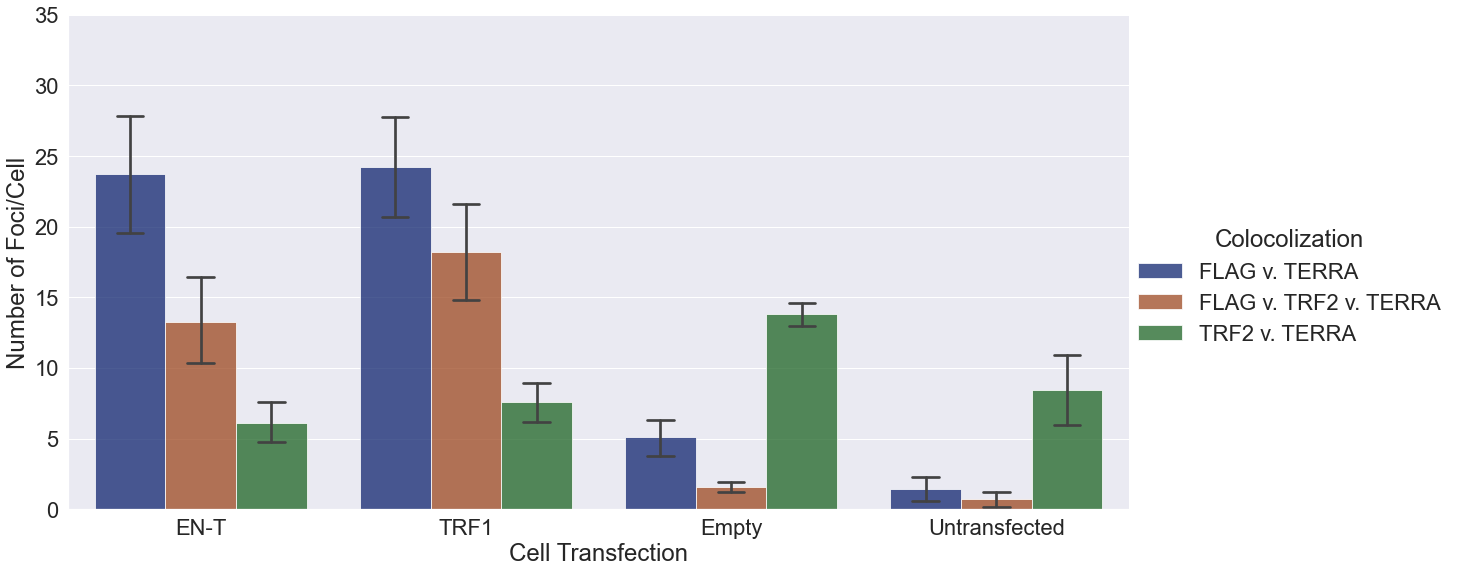

In [21]:
#Show the increased levels of TRF2-TERRA to support that free TERRA is recreuited to telo DSB's
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8, aspect=2, order=["EN-T","TRF1","Empty","Untransfected"],
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Number of Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,35))
#plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_EvTvEMPvUntrans.png', dpi=900, bbox_inches='tight')

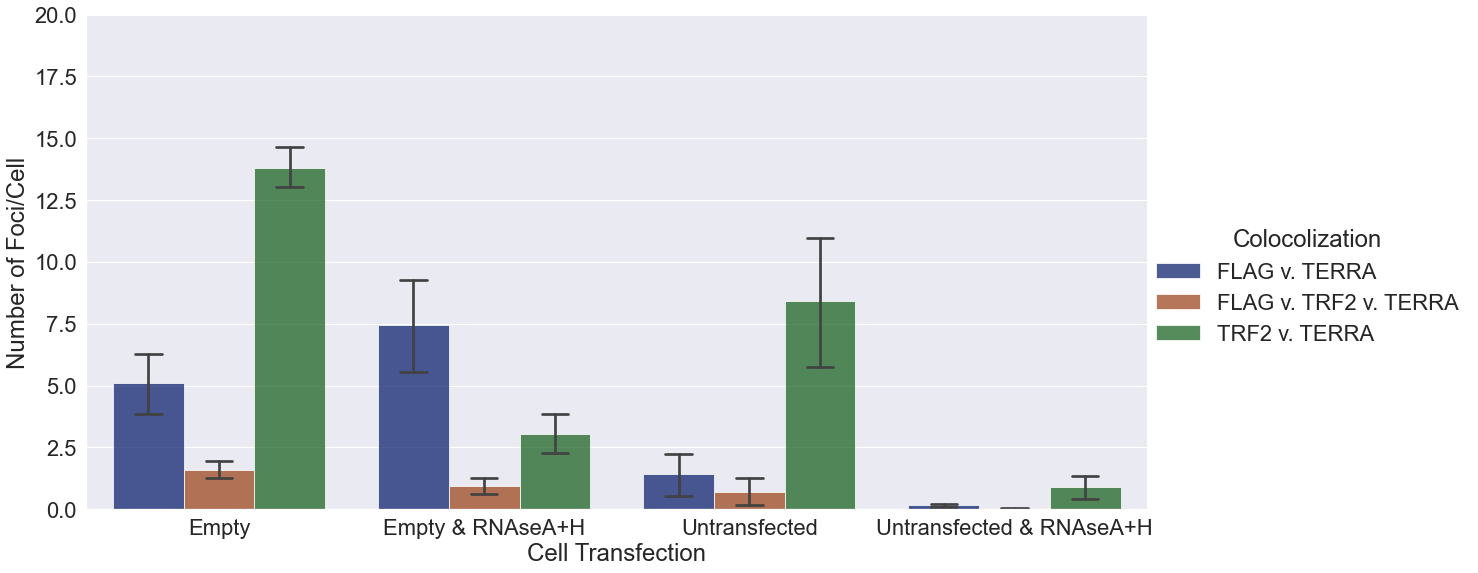

In [22]:
#Show the effects of +RNAse on our control cells
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="Foci per Cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8,
    aspect=2, order=["Empty","Empty & RNAseA+H","Untransfected","Untransfected & RNAseA+H"],
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Number of Foci/Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,20))
#plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_EMPvUntranswRNAse.png', dpi=900, bbox_inches='tight')

In [23]:
# Only did b/w TRF1 and then Empty or Untrans because we say TRF1 and EN-T are not stat. diff

# T vs/ empty on FLag
jj = stats.f_oneway(telo_cell_df['Empty & RNAseA+H'].iloc[:10],
               telo_cell_df['Empty'].iloc[:10],
                                 )

# T vs/ empty on tri
kk =stats.f_oneway(telo_cell_df['Empty & RNAseA+H'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

# T vs/ empty on TRF2
ll = stats.f_oneway(telo_cell_df['Empty & RNAseA+H'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

# T vs/ untrans on flag
mm = stats.f_oneway(telo_cell_df['Untransfected & RNAseA+H'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[:10],
                                 )

# T vs/ untrans on tri
nn = stats.f_oneway(telo_cell_df['Untransfected & RNAseA+H'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

# T vs/ untrans on TRF2
oo = stats.f_oneway(telo_cell_df['Untransfected & RNAseA+H'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

print(jj,'Empty Flag\n',kk,'Empty tri\n',ll,'Empty TRF2\n',
      mm,'untrans Flag\n',nn,'Untrans tri\n',oo,'Untrans TRF2\n')


F_onewayResult(statistic=1.0306521089789853, pvalue=0.3234582435556208) Empty Flag
 F_onewayResult(statistic=0.9516985291022595, pvalue=0.3438072343591161) Empty tri
 F_onewayResult(statistic=0.9516985291022595, pvalue=0.3438072343591161) Empty TRF2
 F_onewayResult(statistic=2.157477614306295, pvalue=0.1591375523901747) untrans Flag
 F_onewayResult(statistic=1.5912050116123386, pvalue=0.22523578715482456) Untrans tri
 F_onewayResult(statistic=1.5912050116123386, pvalue=0.22523578715482456) Untrans TRF2



## Extra Stats

### INTER-cell stats

In [24]:
#ANOVA between all colocolizations
all_coloc_anova =stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

#ANOVA between FlagT and Tri 
Fv3_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               )

#ANOVA between TRF1T and tri
Tv3_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

#ANOVA between TRF1T and FlagT 
TvF_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

print( all_coloc_anova,'Between All\n',
       Fv3_coloc_anova,'FlagT vs. tricolocolization\n',
       Tv3_coloc_anova, 'TRF2T vs. tricolocolization\n',
       TvF_coloc_anova, 'TRF2T vs. FlagT\n'
     )

#All sig diff except for TRF2 v. tri – shows that TRF2 drives the colocolization ––– could do SHAP if we wanted

F_onewayResult(statistic=10.940635828613273, pvalue=2.85268594584366e-05) Between All
 F_onewayResult(statistic=11.086851684615443, pvalue=0.001082125011747382) FlagT vs. tricolocolization
 F_onewayResult(statistic=0.3102180748753634, pvalue=0.5783345050786045) TRF2T vs. tricolocolization
 F_onewayResult(statistic=17.035335750219406, pvalue=5.922132154126668e-05) TRF2T vs. FlagT



In [25]:
# Tukey to confirm the colocolization differences
coloc_tukey = pairwise_tukeyhsd(endog=telo_df['Foci per Cell'],
                          groups=telo_df['Colocolization'],
                          alpha=0.05)

print(coloc_tukey)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
        group1                group2        meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------------------
        FLAG v. TERRA FLAG v. TRF2 v. TERRA  -5.6226 0.001 -9.1012 -2.1441   True
        FLAG v. TERRA         TRF2 v. TERRA   -6.273 0.001 -9.7516 -2.7945   True
FLAG v. TRF2 v. TERRA         TRF2 v. TERRA  -0.6504 0.892 -4.1289  2.8282  False
---------------------------------------------------------------------------------


In [26]:
#Compare FLAG b/w EN-T and TRF1
a = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['TRF1'].iloc[:10],
                               )
#Compare tricolocolizations b/w EN-T and TRF1
b =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['TRF1'].iloc[11:20],
                                 )
#Compare TRF2's b/w EN-T and TRF1
c = stats.f_oneway(telo_cell_df['EN-T'].iloc[21:],
               telo_cell_df['TRF1'].iloc[21:],
                                 )
print(a,'EvTFLAG\n',b,'EvTtri\n',c,'EvTTRF2\n')



# T vs/ empty on FLAG
j = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['Empty'].iloc[:10],
                                 )
# T vs/ empty on tri
k =stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )
# T vs/ empty on TRF2
l = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )
print(j,'TvemFlag\n',k,'Tvemtri\n',l,'TvemTRF2\n')
      

    
# T vs/ untrans on flag
m = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[:10],
                                 )
# T vs/ untrans on tri
n = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )
# T vs/ untrans on TRF2
o = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )
print(m,'TvunFlag\n',n,'Tvuntri\n',o,'TvunTRF2\n')



# EN-T vs/ untrans on flag
p = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[:10],
                                 )
# EN-T vs/ untrans on tri
q = stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )
# EN-T vs/ untrans on TRF2
r = stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )
print(p,'EvunFlag\n',q,'Evuntri\n',r,'EvunTRF2\n')



# EN-T vs/ empty on FLAG
s = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['Empty'].iloc[:10],
                                 )
# EN-T vs/ empty on tri
t =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )
# EN-T vs/ empty on TRF2
u = stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )
print(s,'EvemFlag\n',t,'Evemtri\n',u,'EvemTRF2\n')



# Empty vs/ untrans on flag
v = stats.f_oneway(telo_cell_df['Empty'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[:10],
                                 )
# EN-T vs/ untrans on tri
w = stats.f_oneway(telo_cell_df['Empty'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )
# EN-T vs/ untrans on TRF2
x = stats.f_oneway(telo_cell_df['Empty'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )
print(v,'emvunFlag\n',w,'emvuntri\n',x,'emvunTRF2\n')

F_onewayResult(statistic=0.0074907920174264305, pvalue=0.9319852347203408) EvTFLAG
 F_onewayResult(statistic=1.0146976237782777, pvalue=0.32877203658344184) EvTtri
 F_onewayResult(statistic=0.6622384330590622, pvalue=0.42771618130047206) EvTTRF2

F_onewayResult(statistic=22.9040206361094, pvalue=0.00014790840055757597) TvemFlag
 F_onewayResult(statistic=21.048542733031045, pvalue=0.00030324510734208693) Tvemtri
 F_onewayResult(statistic=21.048542733031045, pvalue=0.00030324510734208693) TvemTRF2

F_onewayResult(statistic=34.732299828888685, pvalue=1.4029589978226206e-05) TvunFlag
 F_onewayResult(statistic=22.646952255330238, pvalue=0.00021351344139676102) Tvuntri
 F_onewayResult(statistic=22.646952255330238, pvalue=0.00021351344139676102) TvunTRF2

F_onewayResult(statistic=25.011867351213517, pvalue=9.260331269191456e-05) EvunFlag
 F_onewayResult(statistic=13.62977501119603, pvalue=0.001976077190982996) Evuntri
 F_onewayResult(statistic=13.62977501119603, pvalue=0.001976077190982996) E

In [27]:
# Tukey to confirm the overall means of the different cells
cellcond_tukey = pairwise_tukeyhsd(endog=telo_df['Foci per Cell'],
                          groups=telo_df['Cell_condition'],
                          alpha=0.05)

print(cellcond_tukey)


               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1               group2          meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H  -7.3605 0.0167 -13.9438 -0.7772   True
            EN-T                    Empty  -7.5286 0.0129 -14.1119 -0.9453   True
            EN-T         Empty & RNAseA+H -10.5545  0.001 -17.1378 -3.9711   True
            EN-T                     TRF1   2.2998    0.9  -4.2835  8.8831  False
            EN-T          TRF1 & RNAseA+H  -5.6402 0.1539 -12.2235  0.9431  False
            EN-T            Untransfected -10.8442  0.001 -17.4275 -4.2609   True
            EN-T Untransfected & RNAseA+H  -13.997  0.001 -20.5803 -7.4137   True
 EN-T & RNAseA+H                    Empty  -0.1681    0.9  -6.7515  6.4152  False
 EN-T & RNAseA+H         Empty & RNAseA+H   -3.194 0.7911  -9.7773  3.3893  False
 EN-T & RNAseA+H

In [28]:
telo_coloc_df

# Tukey between all cells over FLAG v. TERRA for foci/cell
FvT_all_tukey = pairwise_tukeyhsd(endog=telo_coloc_df['FLAG v. TERRA'],
                          groups=telo_coloc_df['Cell Condition'],
                          alpha=0.05)

# Tukey between all cells over tri coloc for foci/cell
tri_all_tukey = pairwise_tukeyhsd(endog=telo_coloc_df['FLAG v. TRF2 v. TERRA'],
                          groups=telo_coloc_df['Cell Condition'],
                          alpha=0.05)

# Tukey between all cells over TRF2 v. TERRA for foci/cell
TrvT_all_cell = pairwise_tukeyhsd(endog=telo_coloc_df['TRF2 v. TERRA'],
                          groups=telo_coloc_df['Cell Condition'],
                          alpha=0.05)

print(FvT_all_tukey, 'FLAG v. TERRA \n',
      tri_all_tukey, 'tri coloc\n',
      TrvT_all_cell, 'TRF2 v. TERRA\n',
      )

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
     group1               group2          meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H  -9.3707  0.277 -21.7659   3.0246  False
            EN-T                    Empty -18.6058  0.001 -31.0011  -6.2106   True
            EN-T         Empty & RNAseA+H -16.2652 0.0026 -28.6604  -3.8699   True
            EN-T                     TRF1   0.5001    0.9 -11.8951  12.8954  False
            EN-T          TRF1 & RNAseA+H  -7.0846 0.6154 -19.4799   5.3107  False
            EN-T            Untransfected -22.2956  0.001 -34.6909  -9.9004   True
            EN-T Untransfected & RNAseA+H -23.5505  0.001 -35.9458 -11.1553   True
 EN-T & RNAseA+H                    Empty  -9.2352 0.2945 -21.6304   3.1601  False
 EN-T & RNAseA+H         Empty & RNAseA+H  -6.8945 0.6433 -19.2898   5.5007  False
 EN-

### INTRA-cell stats


In [77]:
#ANOVAs comparing the differeent colocolizations per each cell type
#Compare FLAG & tri EN-T 
EFLAGvtri = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['EN-T'].iloc[11:20],
                               )
#Compare tri & TRF2 b/w EN-T 
EtrivTRF2 =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['EN-T'].iloc[21:],
                         )
#Compare FLAG & TRF2 b/w EN-T
EFLAGvTRF2 = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['EN-T'].iloc[21:],
                                 )                      
print(EFLAGvtri,'EFLAGvtri\n',EtrivTRF2,'EtrivTRF2\n',EFLAGvTRF2,'EFLAGvTRF2\n')


#Compare FLAG & tri TRF1 
TFLAGvtri = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['TRF1'].iloc[11:20],
                               )
#Compare tri & TRF2 b/w TRF1
TtrivTRF2 =stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['TRF1'].iloc[21:],
                         )
#Compare FLAG & TRF2 b/w TRF1
TFLAGvTRF2 = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['TRF1'].iloc[21:],
                                 )                      
print(TFLAGvtri,'TFLAGvtri\n',TtrivTRF2,'TtrivTRF2\n',TFLAGvTRF2,'TFLAGvTRF2\n')



#Compare FLAG & tri Empty
emFLAGvtri = stats.f_oneway(telo_cell_df['Empty'].iloc[:10],
               telo_cell_df['Empty'].iloc[11:20],
                               )
#Compare tri & TRF2 b/w Empty
emtrivTRF2 =stats.f_oneway(telo_cell_df['Empty'].iloc[11:20],
               telo_cell_df['Empty'].iloc[21:],
                         )
#Compare FLAG & TRF2 b/w Empty
emFLAGvTRF2 = stats.f_oneway(telo_cell_df['Empty'].iloc[:10],
               telo_cell_df['Empty'].iloc[21:],
                                 )                      
print(emFLAGvtri,'emFLAGvtri\n',emtrivTRF2,'emtrivTRF2\n',emFLAGvTRF2,'emFLAGvTRF2\n')



#Compare FLAG & tri Untransfected
unFLAGvtri = stats.f_oneway(telo_cell_df['Untransfected'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[11:20],
                               )
#Compare tri & TRF2 b/w Untransfected
untrivTRF2 =stats.f_oneway(telo_cell_df['Untransfected'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[21:],
                         )
#Compare FLAG & TRF2 b/w Untransfected
unFLAGvTRF2 = stats.f_oneway(telo_cell_df['Untransfected'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[21:],
                                 )                      
print(unFLAGvtri,'unFLAGvtri\n',untrivTRF2,'untrivTRF2\n',unFLAGvTRF2,'unFLAGvTRF2\n')

F_onewayResult(statistic=2.9696893971154013, pvalue=0.10297633628518241) EFLAGvtri
 F_onewayResult(statistic=3.5746644060934782, pvalue=0.07691816672006083) EtrivTRF2
 F_onewayResult(statistic=12.382452384407756, pvalue=0.002634028722245029) EFLAGvTRF2

F_onewayResult(statistic=0.9006095208463841, pvalue=0.35591532458520936) TFLAGvtri
 F_onewayResult(statistic=7.151832765536855, pvalue=0.016623842084103647) TtrivTRF2
 F_onewayResult(statistic=14.399837637914935, pvalue=0.001447368213173517) TFLAGvTRF2

F_onewayResult(statistic=6.113545944221669, pvalue=0.02427142184033869) emFLAGvtri
 F_onewayResult(statistic=194.11405263873908, pvalue=2.2995756410466116e-10) emtrivTRF2
 F_onewayResult(statistic=33.12333810166379, pvalue=2.3316621303251656e-05) emFLAGvTRF2

F_onewayResult(statistic=0.3391022925913877, pvalue=0.5679915369382718) unFLAGvtri
 F_onewayResult(statistic=9.024034234763308, pvalue=0.008408980523909825) untrivTRF2
 F_onewayResult(statistic=8.137778175846622, pvalue=0.0110117479

In [79]:
# Tukey to confirm the intra-cell statistics
#For ENT
intra_ENT_tukey = pairwise_tukeyhsd(endog=telo_cell_df['EN-T'],
                          groups=telo_cell_df['Colocolization'],
                          alpha=0.05)

print(intra_ENT_tukey,'ENT\n')

#For TRF1
intra_TRF1_tukey = pairwise_tukeyhsd(endog=telo_cell_df['TRF1'],
                          groups=telo_cell_df['Colocolization'],
                          alpha=0.05)

print(intra_TRF1_tukey,'TRF1\n')

#For Empty
intra_Empty_tukey = pairwise_tukeyhsd(endog=telo_cell_df['Empty'],
                          groups=telo_cell_df['Colocolization'],
                          alpha=0.05)

print(intra_Empty_tukey,'Empty\n')

#For Untransfected
intra_Untrans_tukey = pairwise_tukeyhsd(endog=telo_cell_df['Untransfected'],
                          groups=telo_cell_df['Colocolization'],
                          alpha=0.05)

print(intra_Untrans_tukey,'Untrans\n')

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------
        FLAG v. TERRA FLAG v. TRF2 v. TERRA -10.4499 0.0752 -21.7859  0.8861  False
        FLAG v. TERRA         TRF2 v. TERRA -17.5884 0.0019 -28.9244 -6.2525   True
FLAG v. TRF2 v. TERRA         TRF2 v. TERRA  -7.1385 0.2798 -18.4745  4.1975  False
----------------------------------------------------------------------------------- ENT

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------------------
        FLAG v. TERRA FLAG v. TRF2 v. TERRA  -6.0025 0.3692 -16.8316  4.8266  False
        FLAG v. TERRA         TRF2 v. TERRA -16.6368  0.002 -27.4659 -5

In [72]:
telo_cell_df

,Colocolization,EN-T,TRF1,Empty,Untransfected,EN-T & RNAseA+H,TRF1 & RNAseA+H,Empty & RNAseA+H,Untransfected & RNAseA+H
0,FLAG v. TERRA,25.072727,21.716667,0.904762,0.000000,24.641026,11.380952,7.500000,0.000000
1,FLAG v. TERRA,39.486486,32.428571,13.095238,0.000000,18.000000,29.051724,12.631579,0.000000
2,FLAG v. TERRA,36.553191,35.602564,8.697674,0.000000,26.000000,26.741935,20.509091,0.000000
3,FLAG v. TERRA,44.680851,42.129870,8.916667,8.666667,30.640000,39.086957,4.642857,0.000000
4,FLAG v. TERRA,32.786885,37.803279,7.457143,0.000000,15.264706,18.382979,8.228571,0.000000
5,FLAG v. TERRA,7.719101,10.781513,1.451389,0.023810,4.761905,2.588542,1.081633,0.010695
6,FLAG v. TERRA,8.328042,10.148936,2.840336,1.289941,4.407643,12.328671,5.939189,0.207921
7,FLAG v. TERRA,12.256944,15.745856,2.734807,1.245690,9.547297,12.210145,10.472222,0.609467
8,FLAG v. TERRA,17.636364,22.374150,2.716763,2.540909,6.150327,9.607843,0.901639,0.668712
9,FLAG v. TERRA,12.512500,13.302857,2.160000,0.309942,3.913669,4.807292,2.474453,0.031088


## Distributions

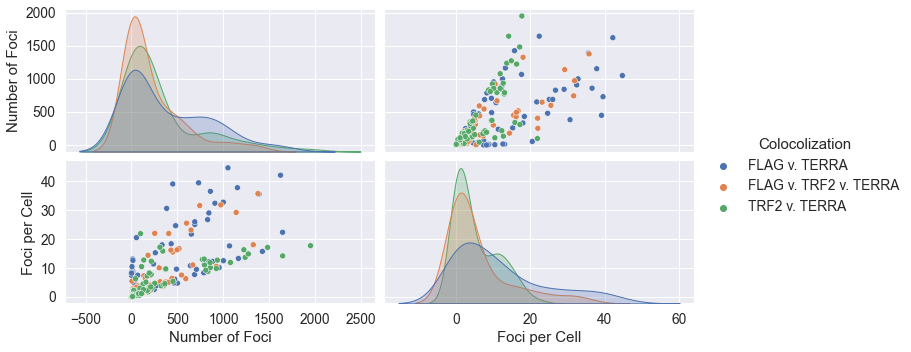

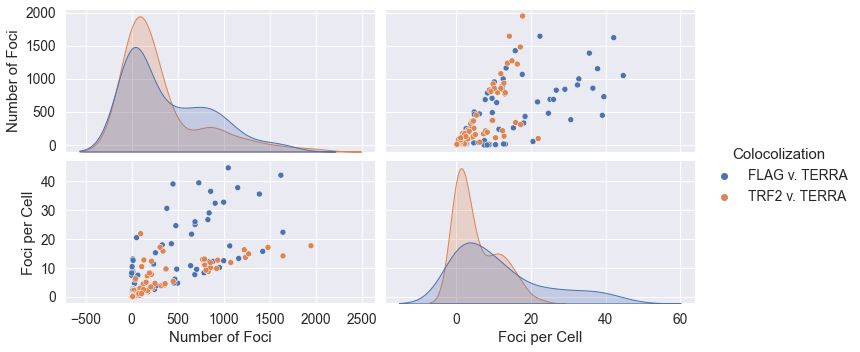

In [29]:
#Seeing the distribution of all the TERRA colocolizations
ax = sns.set(font_scale=1.25)

sns.pairplot(telo_df, hue="Colocolization", aspect=2, #palette="dark"
            )
#plt.title("Distributions of TERRA Colocolizations", x=0, y=2.05)
#plt.legend(bbox_to_anchor=(2.01, 5),
           #borderaxespad=0)

#plt.savefig(f'telo_terra_coloc_distributions.png', dpi=900, bbox_inches='tight')

ax = sns.set(font_scale=1.25)

sns.pairplot(telo_drop_df, hue="Colocolization", aspect=2, #palette="dark"
            )

No handles with labels found to put in legend.


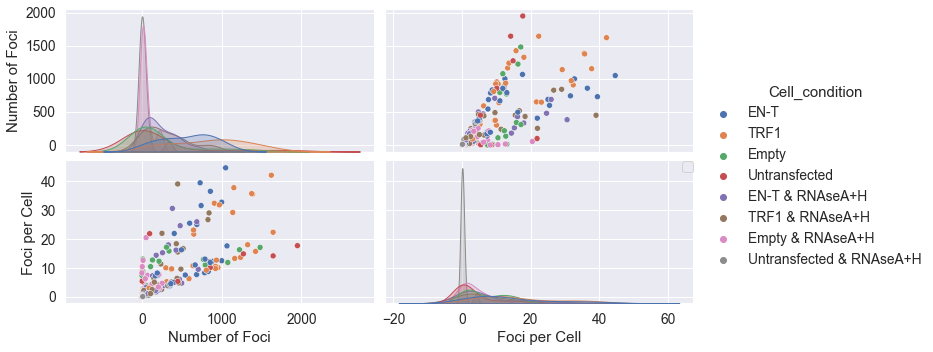

In [30]:
#Seeing if the cell transfection influences TERRA colocoliztion
ax = sns.set(font_scale=1.25)
sns.pairplot(telo_df, hue="Cell_condition", aspect=2, #palette="dark"
            )
#plt.title('Distributions of TERRA Colocolizations', x=0, y=2.05)
plt.legend(bbox_to_anchor=(1, 1),
           borderaxespad=0)

#plt.savefig(f'telo_terra_cell_distributions.png', dpi=900, bbox_inches='tight')

# TERRA locolization to Telomeric DSBs accumulated in the G2 phase of the cell cycle
  - Same experiment but assesed based on cells transfected with:
      - "G1 (stained  ONLY  with DAPI), in S phase (stained with DAPI+EdU) and G2 ( cells stained with green FUCCI and DAPI) and then compared this to the number of TERRA foci in untransfected control."
      - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
      - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
        - a.FLAG  ( to label the positvely transfected cells).
        - b. yH2AX ( DSBs marker)
        - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
        - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).

## Bar Plots

### Whole Data 

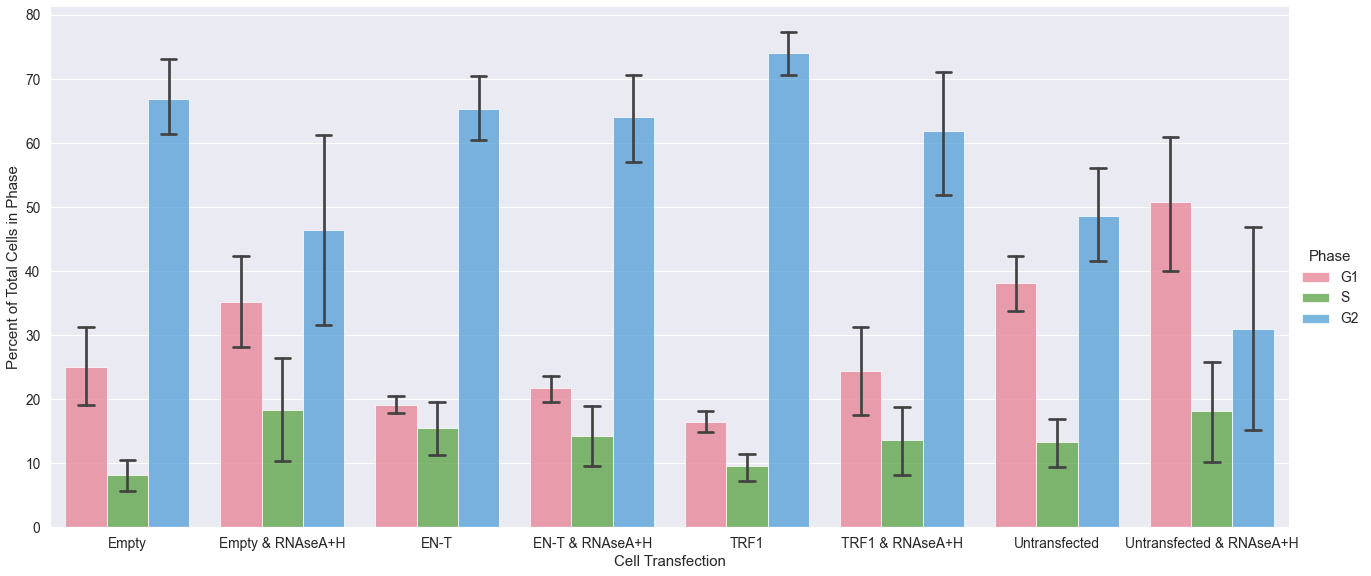

In [31]:
# Catagorical bar plot for PERCENT of cells per phase
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="Cell % In Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2.25
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Percent of Total Cells in Phase")
g.legend.set_title("Phase")
#plt.title("Percent of Cells per Phase")

#plt.savefig(f'g2_cell_percent_whole.png', dpi=900, bbox_inches='tight')

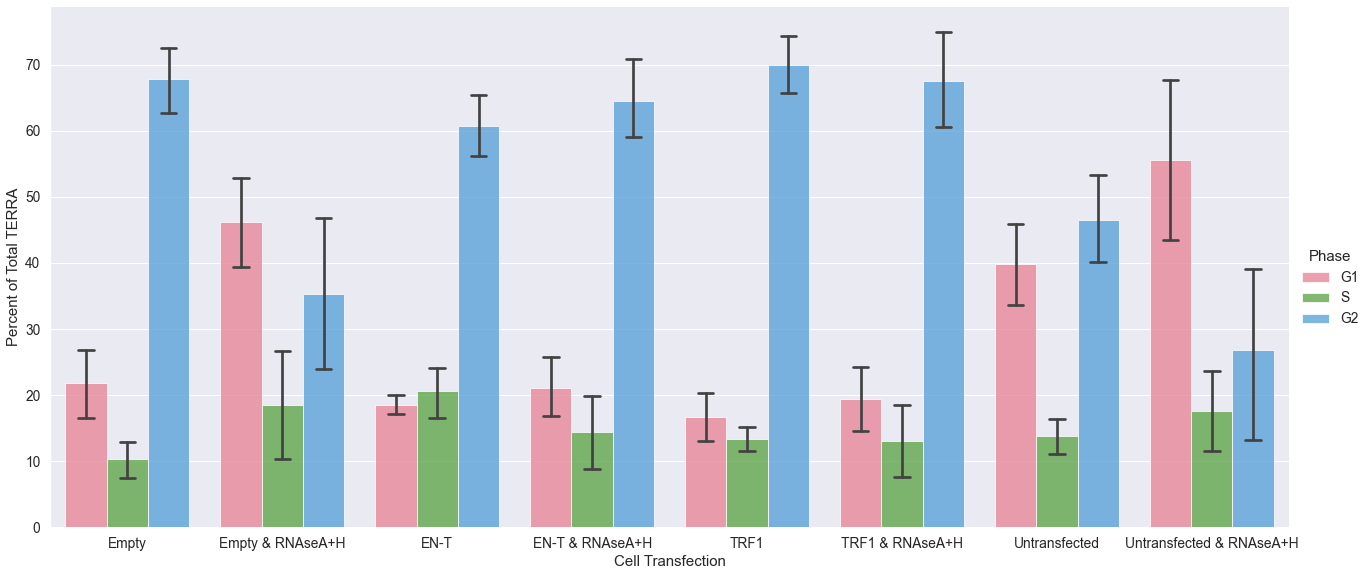

In [32]:
# Catagorical bar plot for percent of TERRA per phase
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA % In Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2.25
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
#plt.title("Percent of TERRA per Phase")

#plt.savefig(f'g2_terra_percent_whole.png', dpi=900, bbox_inches='tight')

### Useful Summary Plots

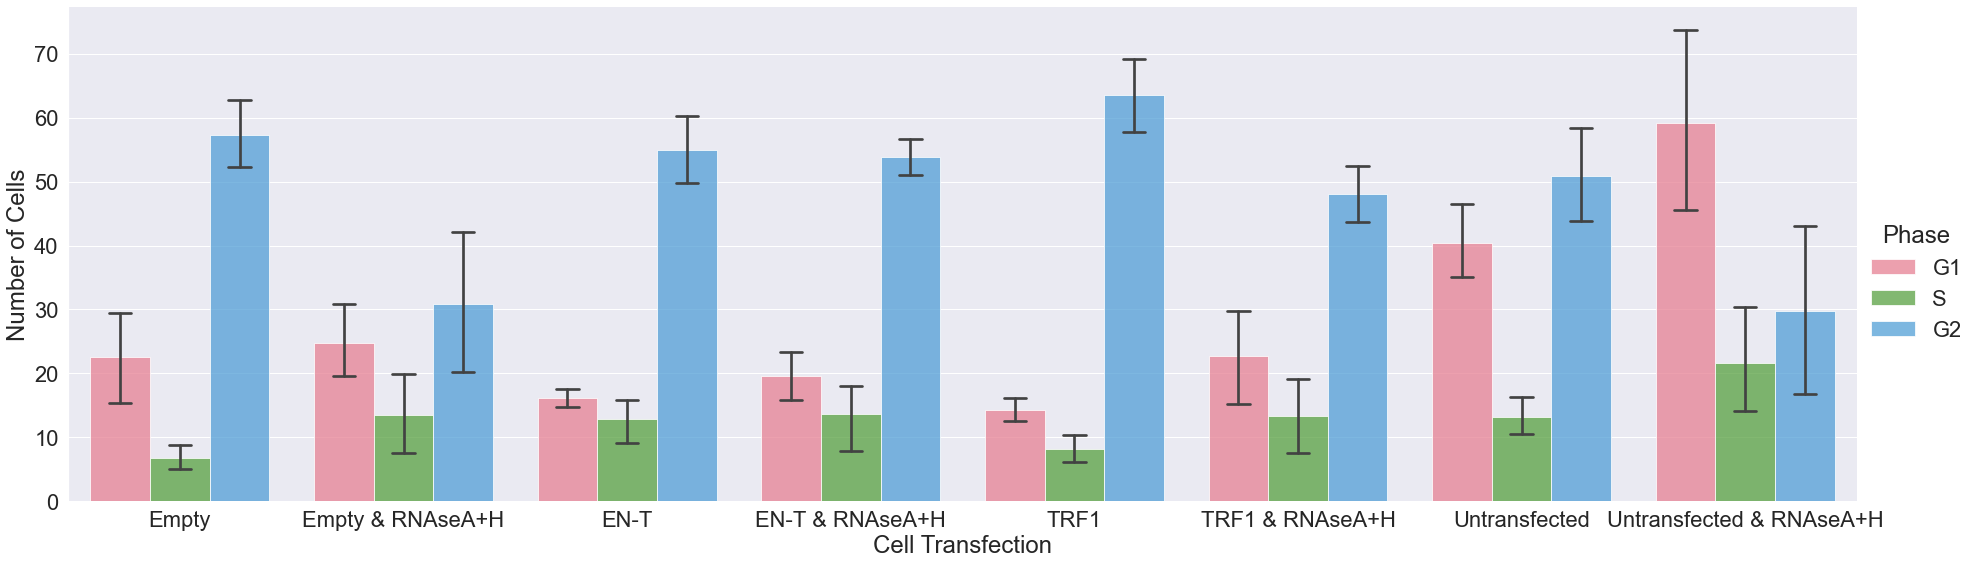

In [33]:
# Catagorical bar plot for CELL AMOUNT i.e.e what phase do cells accumulate
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="Cell Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=3.25,
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Number of Cells")
g.legend.set_title("Phase")
#plt.title("Percent of TERRA per Phase")

#plt.savefig(f'g2_amount_cell_whole.png', dpi=900, bbox_inches='tight')

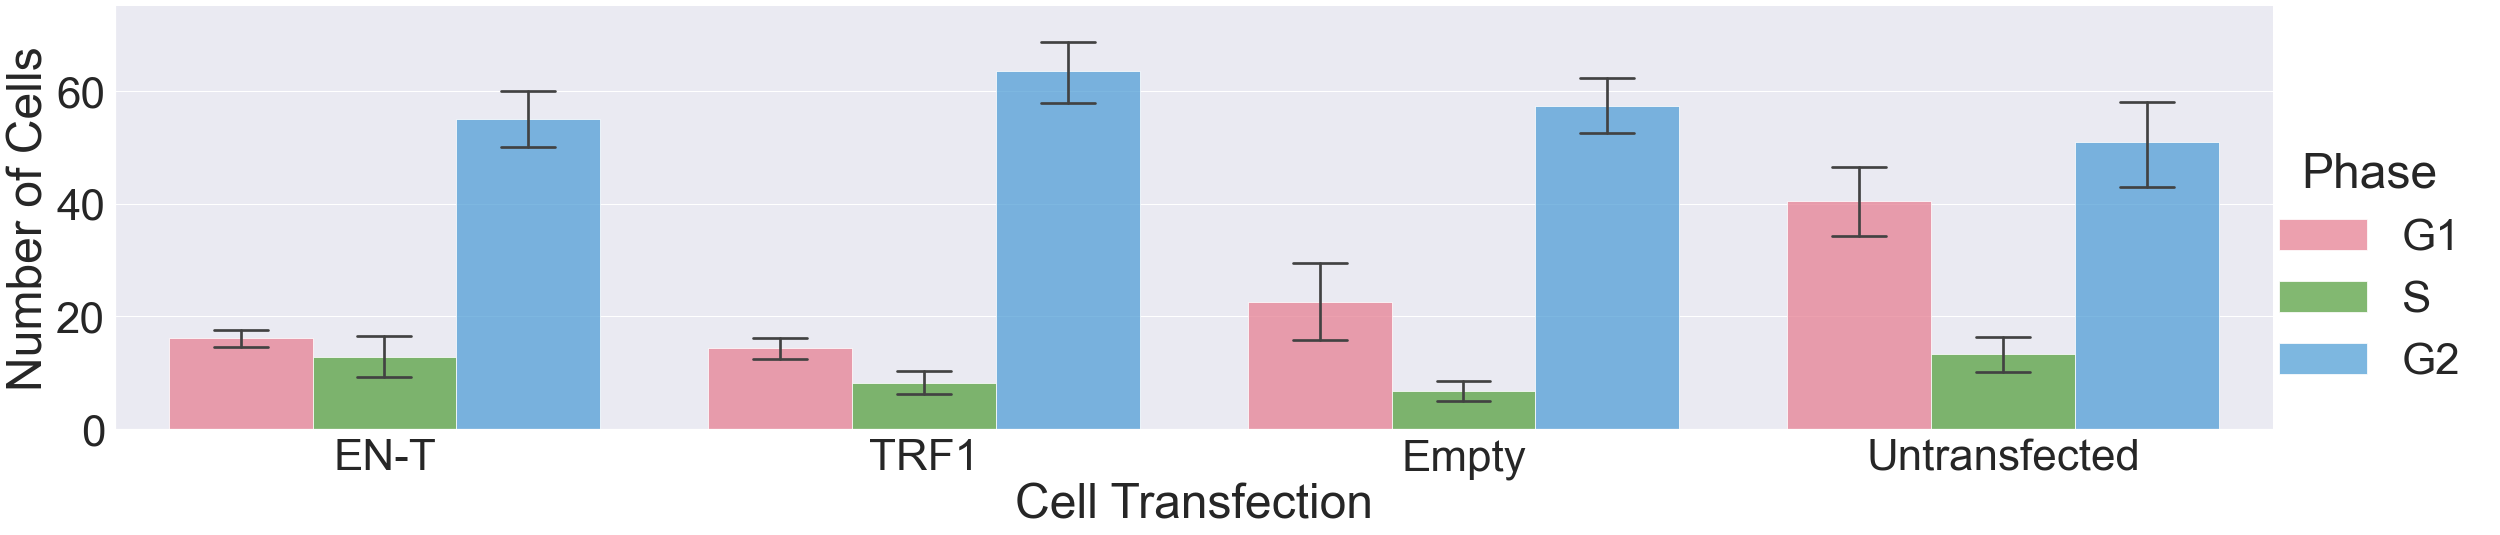

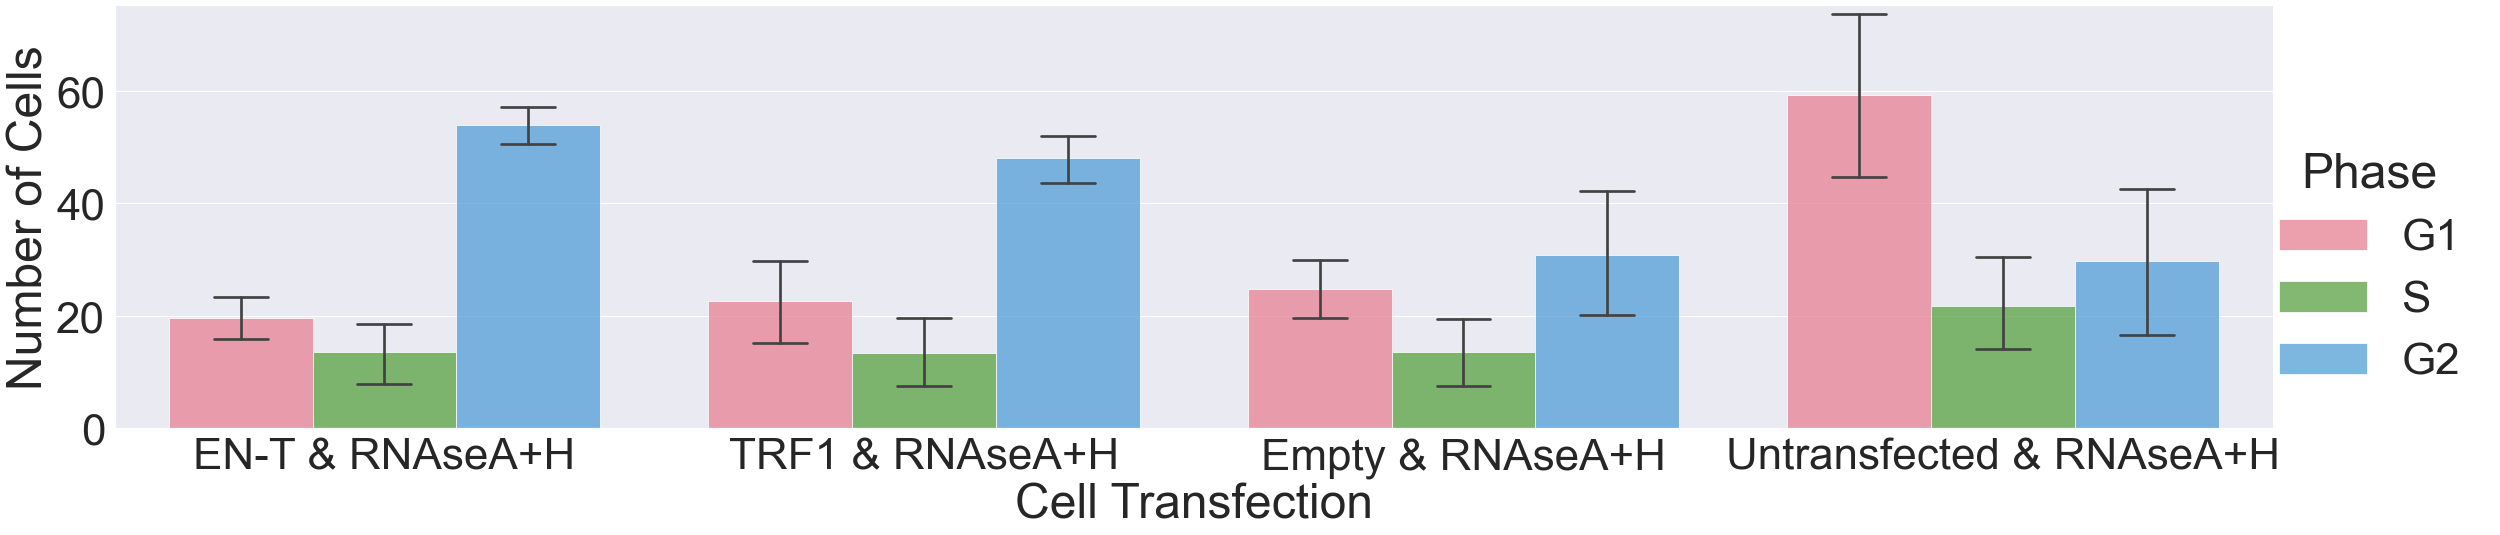

In [34]:
# Catagorical bar plot with all the colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y='Cell Amount', hue="Phase", order = ['EN-T' 
                                                         ,#'EN-T & RNAseA+H',
                                                           'TRF1'
                                                         ,#'TRF1 & RNAseA+H',
                                                         'Empty'
                                                         ,#'Empty & RNAseA+H',
                                                            'Untransfected' 
                                                         ,#'Untransfected & RNAseA+H'
                                                        ],
    palette="husl", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Number of Cells")
g.legend.set_title("Phase")
g.set(ylim=(0,75))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'g2_cell_w-ornase_whole.png', dpi=900, bbox_inches='tight')


# Catagorical bar plot with all the colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y='Cell Amount', hue="Phase", order = [#'EN-T', 
                                                         'EN-T & RNAseA+H'
                                                           #,'TRF1'
                                                         ,'TRF1 & RNAseA+H'
                                                         #,'Empty'
                                                         ,'Empty & RNAseA+H'
                                                           #,'Untransfected' 
                                                         ,'Untransfected & RNAseA+H'
                                                        ],
    palette="husl", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68, 
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Number of Cells")
g.legend.set_title("Phase")
g.set(ylim=(0,75))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'g2_cell_w-rnase_whole.png', dpi=900, bbox_inches='tight')

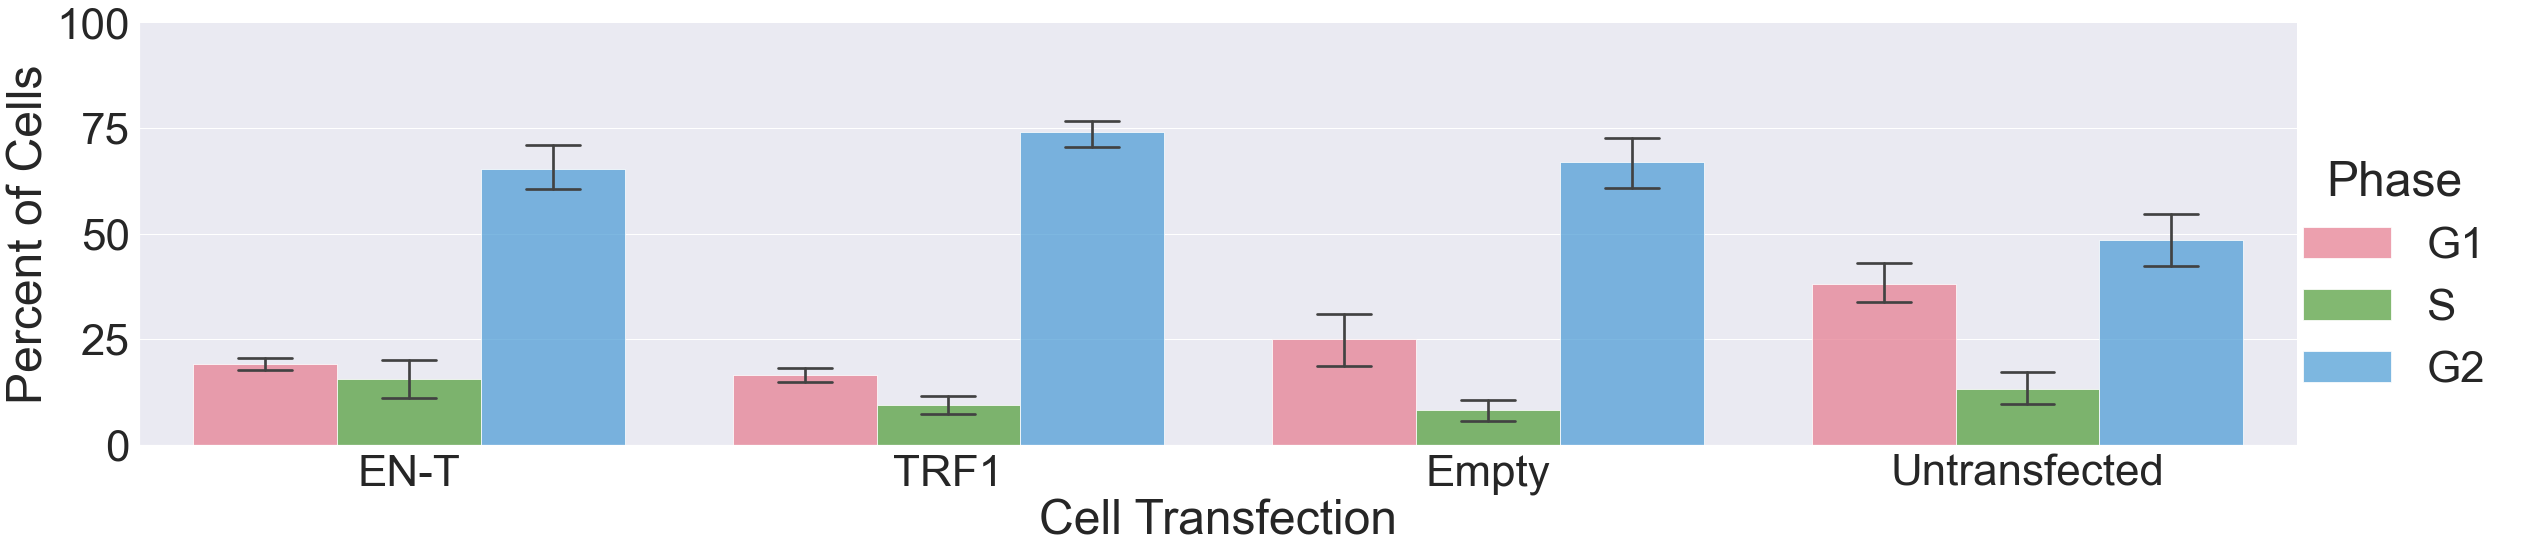

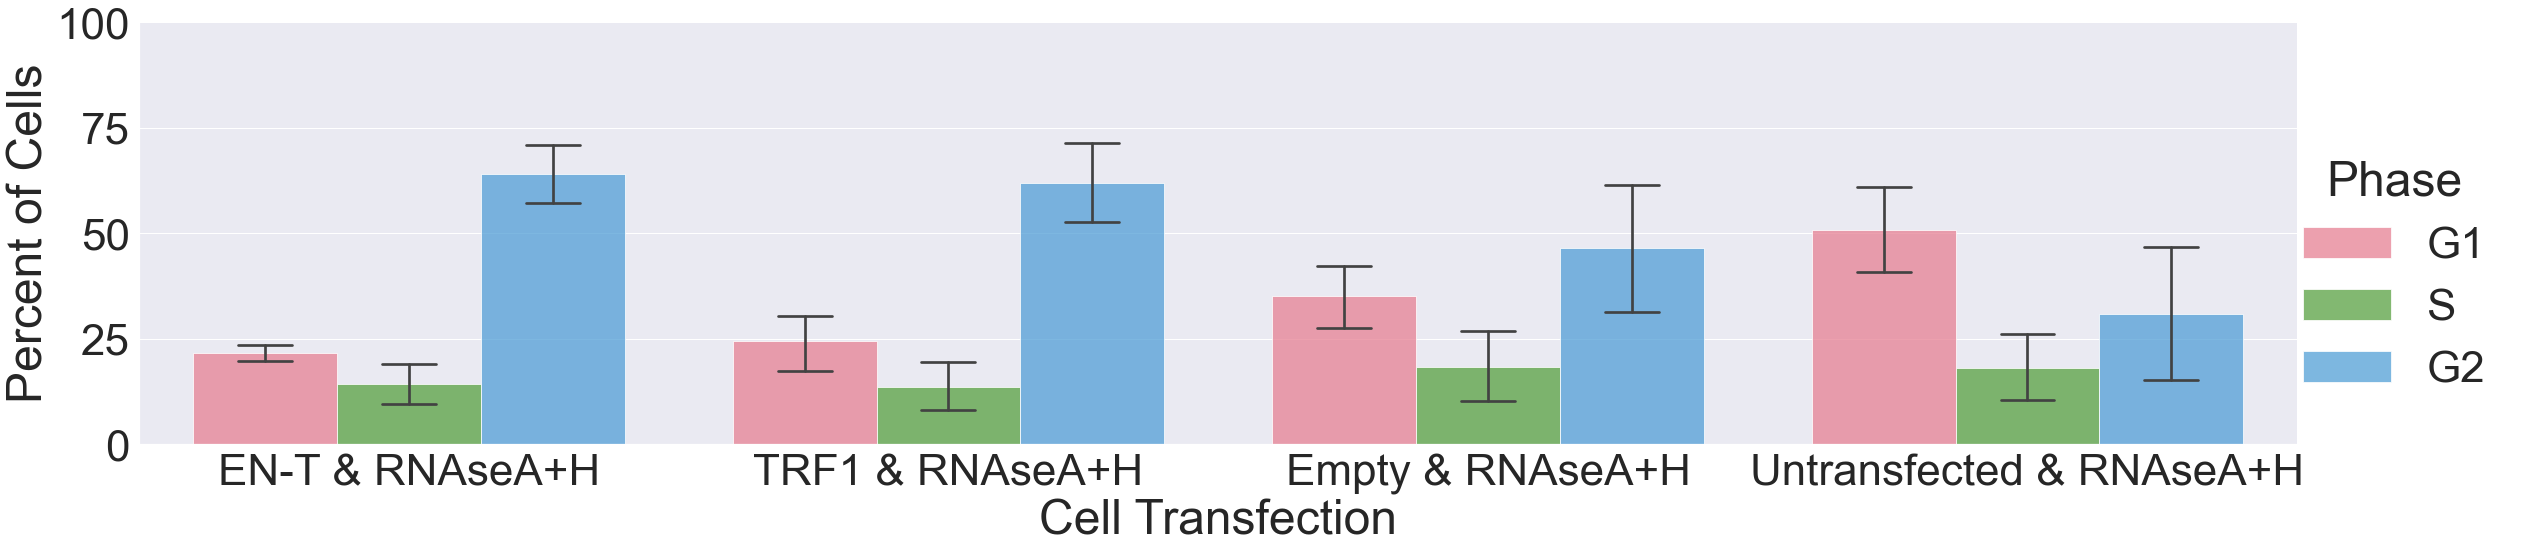

In [35]:
# Catagorical bar plot with all the colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y='Cell % In Phase', hue="Phase", order = ['EN-T' 
                                                         ,#'EN-T & RNAseA+H',
                                                           'TRF1'
                                                         ,#'TRF1 & RNAseA+H',
                                                         'Empty'
                                                         ,#'Empty & RNAseA+H',
                                                            'Untransfected' 
                                                         ,#'Untransfected & RNAseA+H'
                                                        ],
    palette="husl", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Percent of Cells")
g.legend.set_title("Phase")
g.set(ylim=(0,100))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'g2_cell_percent_w-ornase_whole.png', dpi=900, bbox_inches='tight')


# Catagorical bar plot with all the colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y='Cell % In Phase', hue="Phase", order = [#'EN-T', 
                                                         'EN-T & RNAseA+H'
                                                           #,'TRF1'
                                                         ,'TRF1 & RNAseA+H'
                                                         #,'Empty'
                                                         ,'Empty & RNAseA+H'
                                                           #,'Untransfected' 
                                                         ,'Untransfected & RNAseA+H'
                                                        ],
    palette="husl", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68, 
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Percent of Cells")
g.legend.set_title("Phase")
g.set(ylim=(0,100))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'g2_cell_percent_w-rnase_whole.png', dpi=900, bbox_inches='tight')

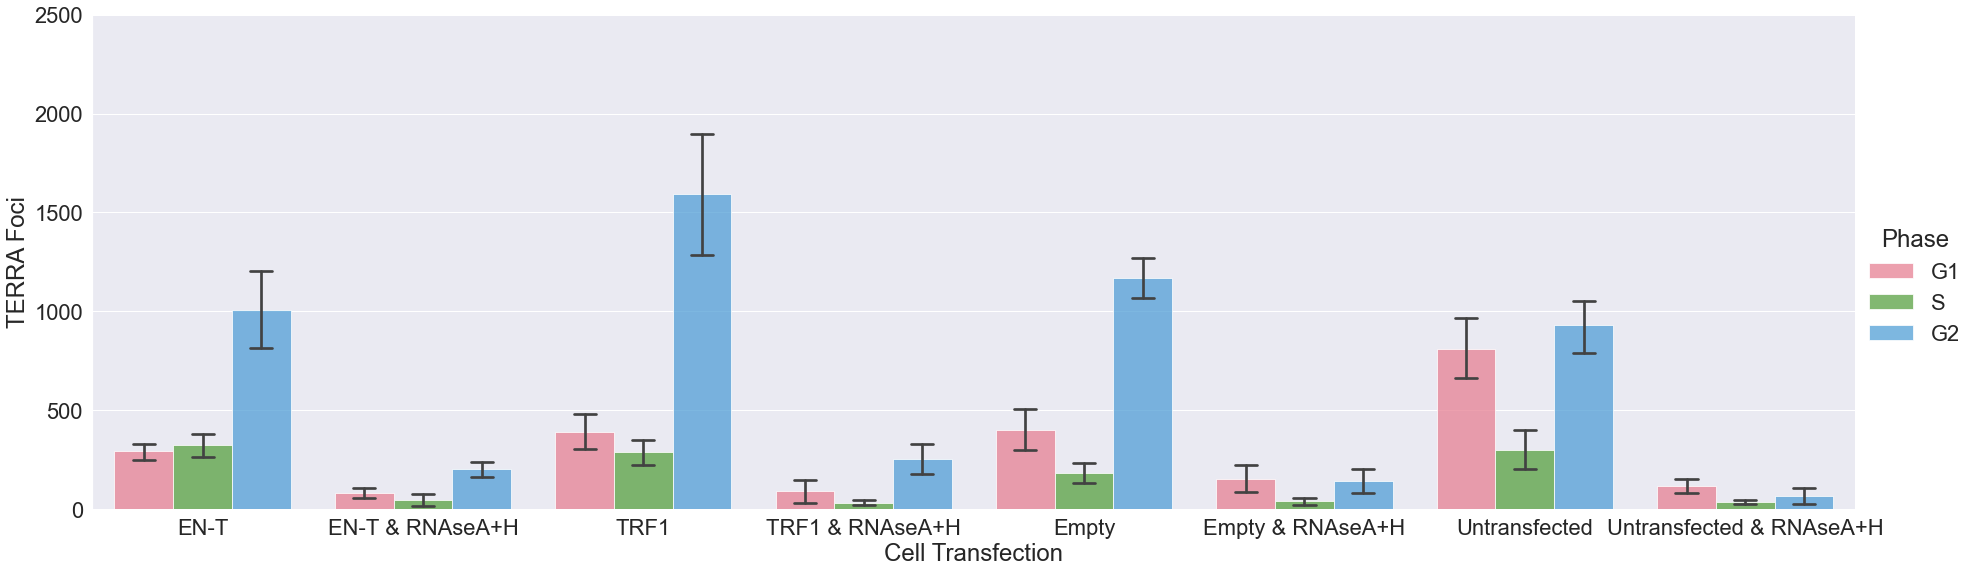

In [36]:
#Show what cell cycle phase TERRA AOMOUNT accumulates in
#g = plt.figure(figsize=(200,10))
#sns.set(rc={'figure.figsize':(200,100)})
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=3.25,
    order = ['EN-T', 'EN-T & RNAseA+H','TRF1','TRF1 & RNAseA+H','Empty', 'Empty & RNAseA+H',
             'Untransfected', 'Untransfected & RNAseA+H']
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "TERRA Foci")
g.legend.set_title("Phase")
#plt.title("Amount of TERRA per Phase")
g.set(ylim=(0,2500))

#plt.savefig(f'g2_amount_terra.png', dpi=900, bbox_inches='tight')

#Same strat as above

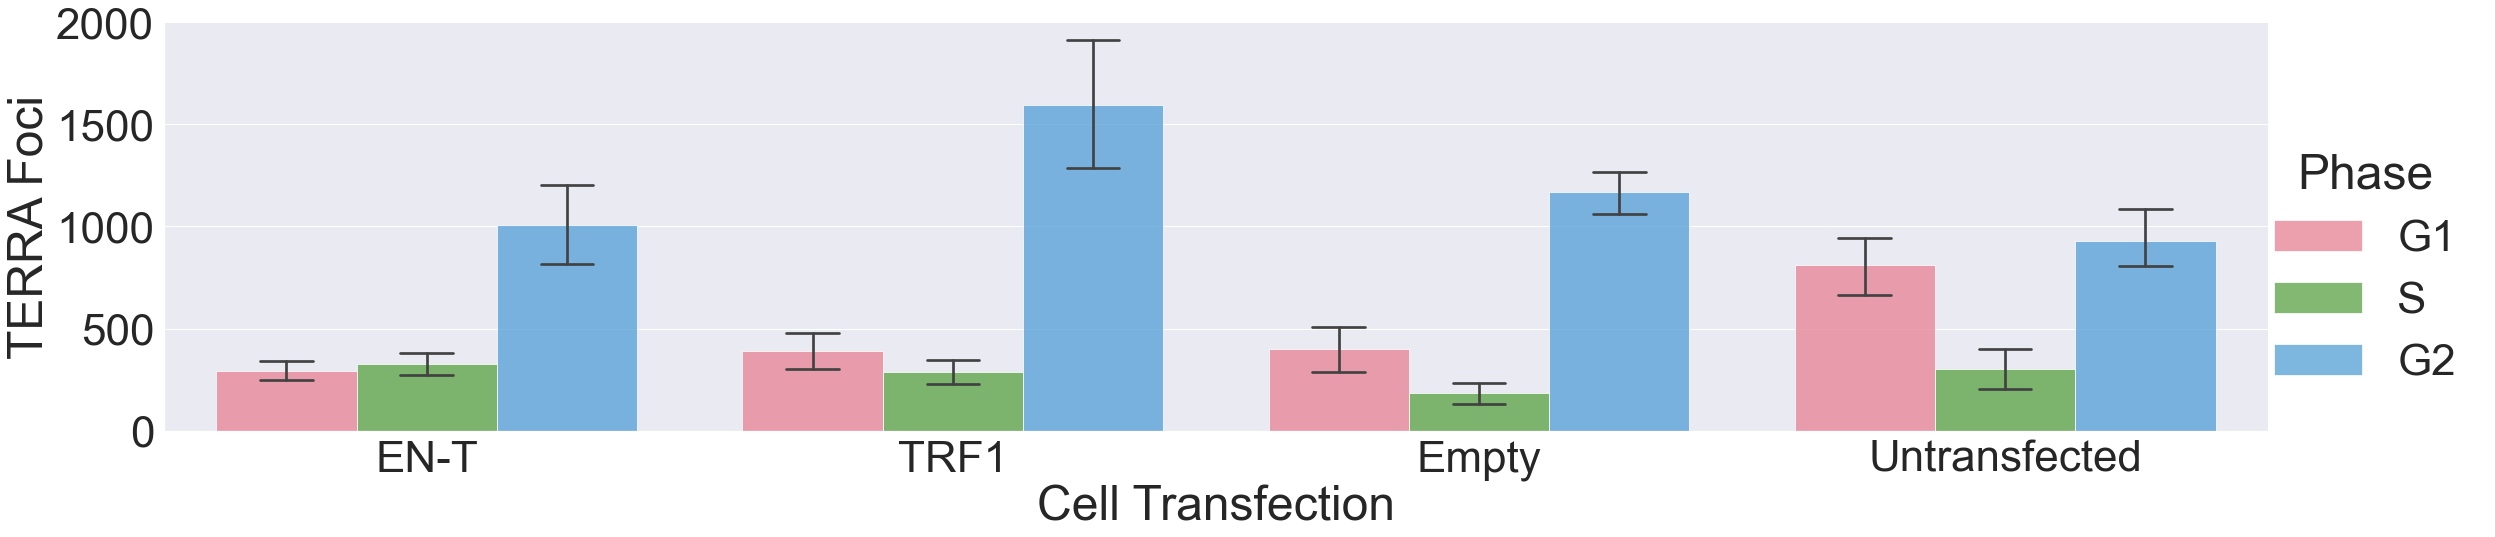

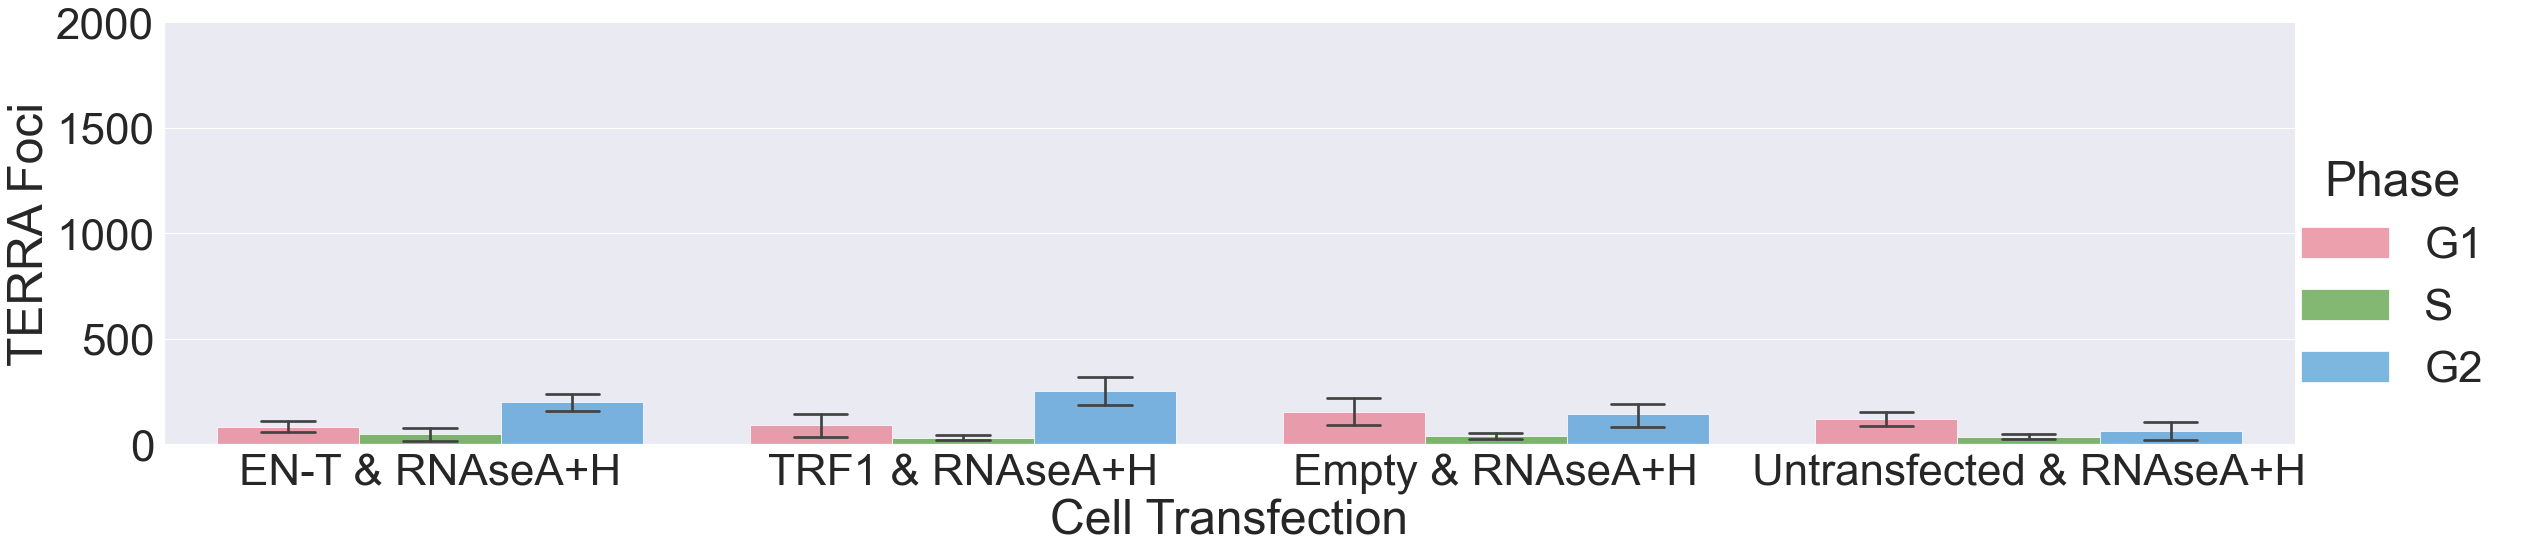

In [37]:
# Catagorical bar plot with all the colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase", order = ['EN-T' 
                                                         ,#'EN-T & RNAseA+H',
                                                           'TRF1'
                                                         ,#'TRF1 & RNAseA+H',
                                                         'Empty'
                                                         ,#'Empty & RNAseA+H',
                                                            'Untransfected' 
                                                         ,#'Untransfected & RNAseA+H'
                                                        ],
    palette="husl", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "TERRA Foci")
g.legend.set_title("Phase")
g.set(ylim=(0,2000))
#plt.title("Average Cololocolized Foci/Cell")


#plt.savefig(f'g2_terra_w-ornase.png', dpi=900, bbox_inches='tight')


# Catagorical bar plot with all the colocolizations
#plt.figure(figsize=(20,10))
#sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=4)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase", order = [#'EN-T', 
                                                         'EN-T & RNAseA+H'
                                                           #,'TRF1'
                                                         ,'TRF1 & RNAseA+H'
                                                         #,'Empty'
                                                         ,'Empty & RNAseA+H'
                                                           #,'Untransfected' 
                                                         ,'Untransfected & RNAseA+H'
                                                        ],
    palette="husl", alpha=.75, height=8, aspect=4,
    capsize=0.1, ci=68, 
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "TERRA Foci")
g.legend.set_title("Phase")
g.set(ylim=(0,2000))
#plt.title("Average Cololocolized Foci/Cell")



#plt.savefig(f'g2_terra_w-rnase_whole.png', dpi=900, bbox_inches='tight')

### Supplimental plots

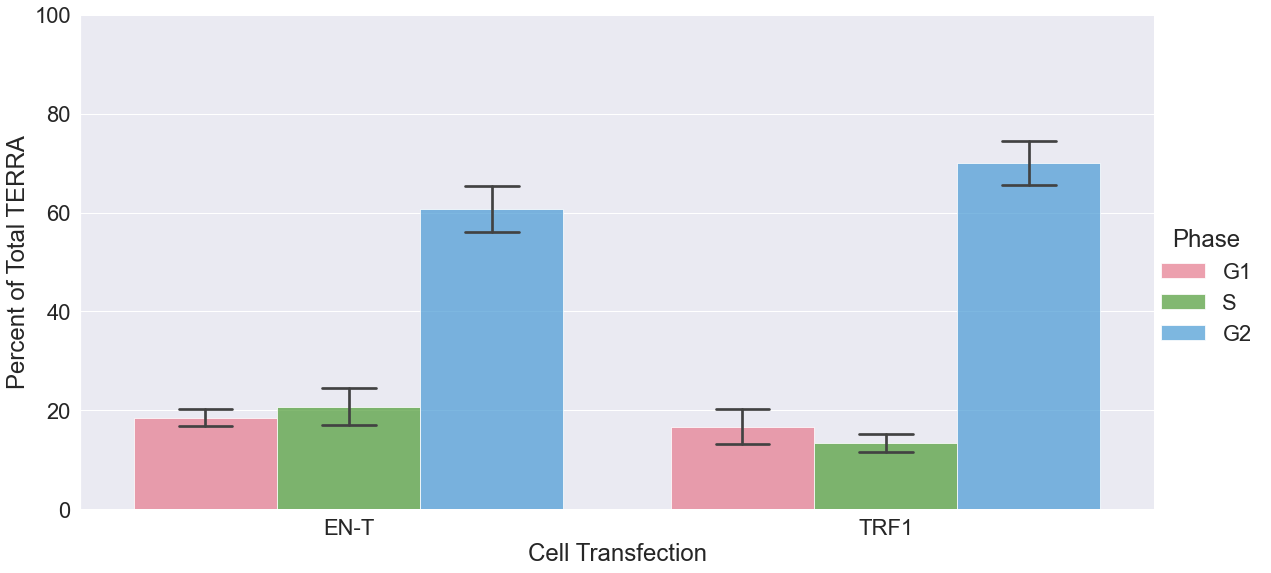

In [38]:
# Show that TERRA accumulates in G2 to Telo DSB's
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA % In Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2, order=['EN-T', 'TRF1'],
)

g.despine(left=False, bottom = True, right=True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
#plt.title("Percent of TERRA per Phase")
g.set(ylim=(0,100))

#plt.savefig(f'g2_ENTvTRF1.png', dpi=900, bbox_inches='tight')

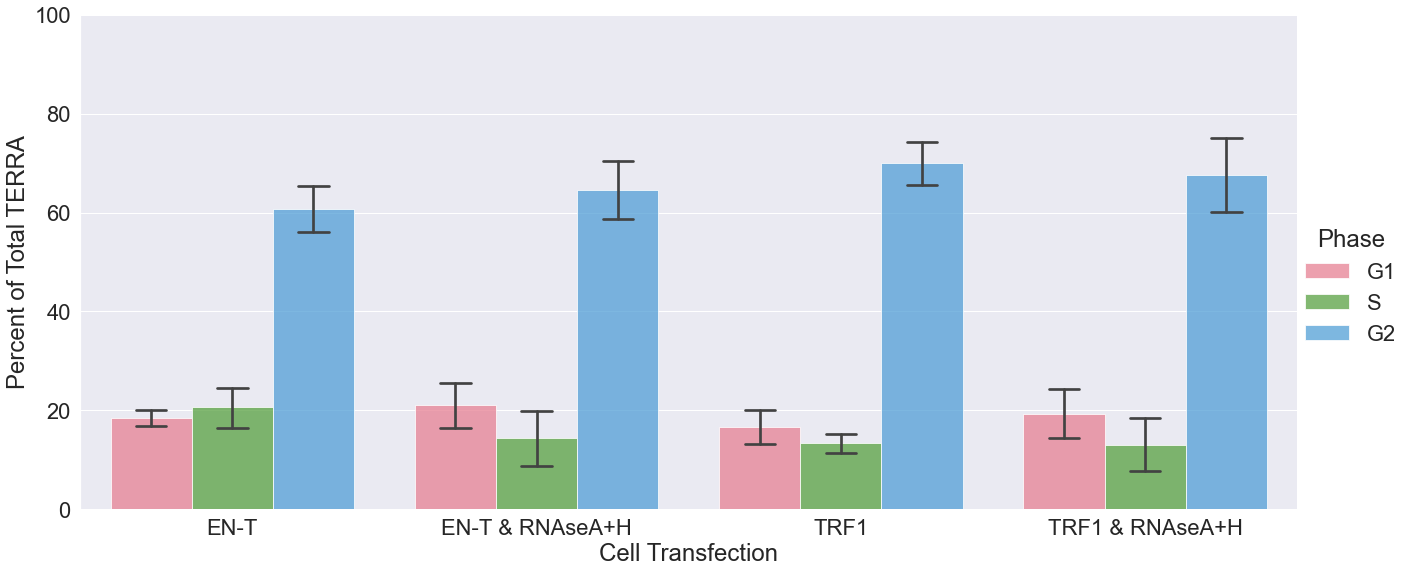

In [39]:
#Show the consistency that TERRA accumulates in G2 even when depleted
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA % In Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2.25,
    order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
#plt.title("Percent of TERRA per Phase")
g.set(ylim=(0,100))

###Note that this is PERCENT, amount of TERRA is below ####

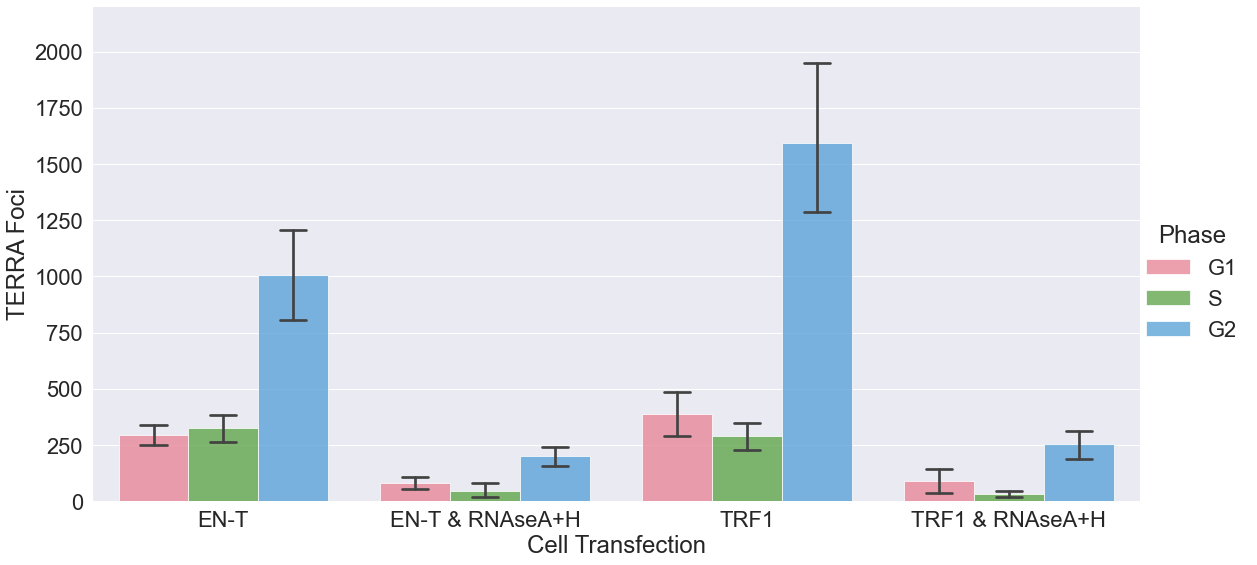

In [40]:
#Show the funky result that RNAse didn't deplete TERRA - consistent across the board
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2,
    order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "TERRA Foci")
g.legend.set_title("Phase")
#plt.title("Amount of TERRA per Phase")
g.set(ylim=(0,2200))

#plt.savefig(f'g2_EvTwRNAse.png', dpi=900, bbox_inches='tight')

In [41]:
#Compare G1 b/w EN-T and EN-T +RNASe 
s = stats.f_oneway(g2_df['TERRA Amount'].loc[30:44],
               g2_df['TERRA Amount'].loc[15:29],
                  )

#Compare TRF1 and TRF1 +RNASe 
t =stats.f_oneway(g2_df['TERRA Amount'].loc[60:74],
               g2_df['TERRA Amount'].loc[75:89],
                   )
                                 
print(s,'EN-T\n',t,'TRF1\n')

F_onewayResult(statistic=13.540340632075512, pvalue=0.0009848034754645887) EN-T
 F_onewayResult(statistic=10.055641228440658, pvalue=0.0036634212243499484) TRF1



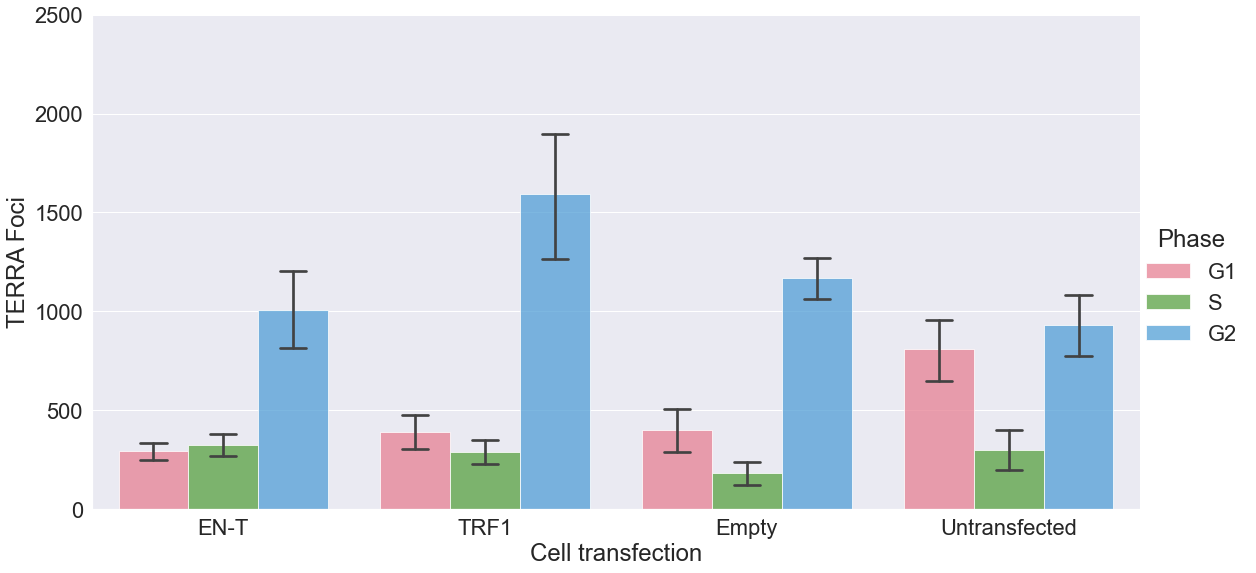

In [42]:
#Show the increased levels of TRF2-TERRA to support that free TERRA is recreuited to telo DSB's
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2,
    order=["EN-T","TRF1","Empty","Untransfected"],
)

g.despine(left=False)
g.set_axis_labels("Cell transfection", "TERRA Foci")
g.legend.set_title("Phase")
g.set(ylim=(0,2500))
#plt.title("Amount of TERRA per Phase")

#plt.savefig(f'g2_EvTvEMPvUntrans.png', dpi=900, bbox_inches='tight')

In [43]:
#Compare Empty vs. TRF1
uu = stats.f_oneway(g2_df['TERRA Amount'].loc[60:74],
               g2_df['TERRA Amount'].loc[:14],
                  )

#Compare untrans vs. TRF1
vv =stats.f_oneway(g2_df['TERRA Amount'].loc[90:104],
               g2_df['TERRA Amount'].loc[60:74],
                   )

                                 
print(uu,'T v.empty\n',vv,'T v.Untrans\n')

F_onewayResult(statistic=0.5565154181739087, pvalue=0.46188523302078743) T v.empty
 F_onewayResult(statistic=0.12065314429277155, pvalue=0.7309246223384973) T v.Untrans



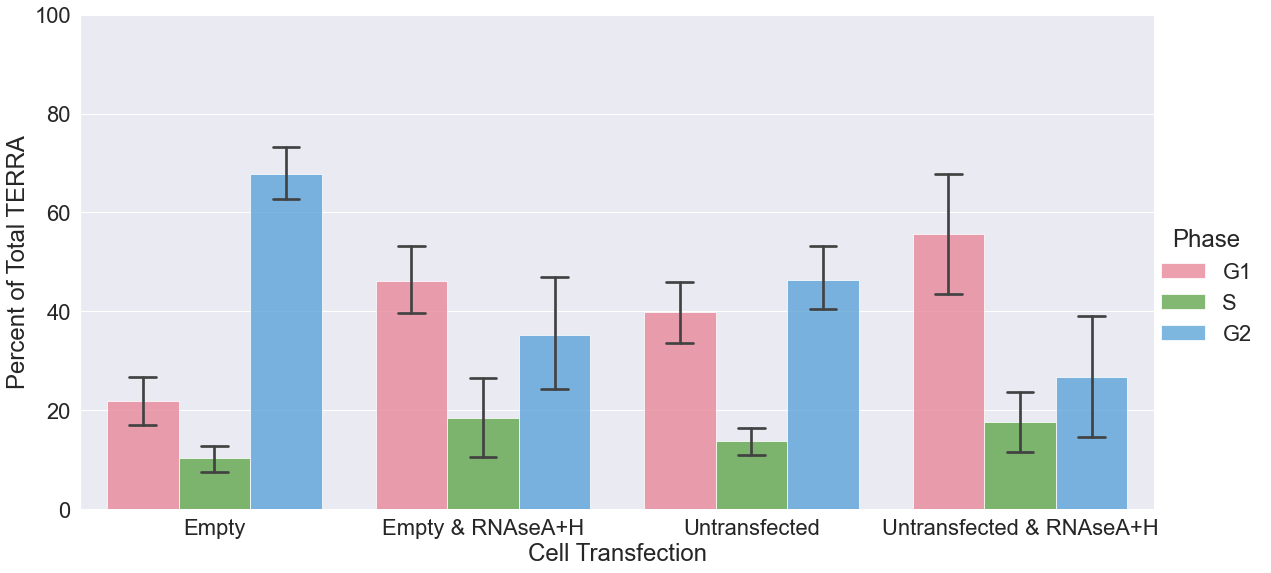

In [44]:
#Shows that with RNAse, TERRA accumulates in G1 for these cells
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA % In Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2,
    order=["Empty","Empty & RNAseA+H", "Untransfected","Untransfected & RNAseA+H"],  
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
#plt.title("Percent of TERRA per Phase")
g.set(ylim=(0,100))

### Note that this is PERCENT of TERRA, amount of TERRA is below ###

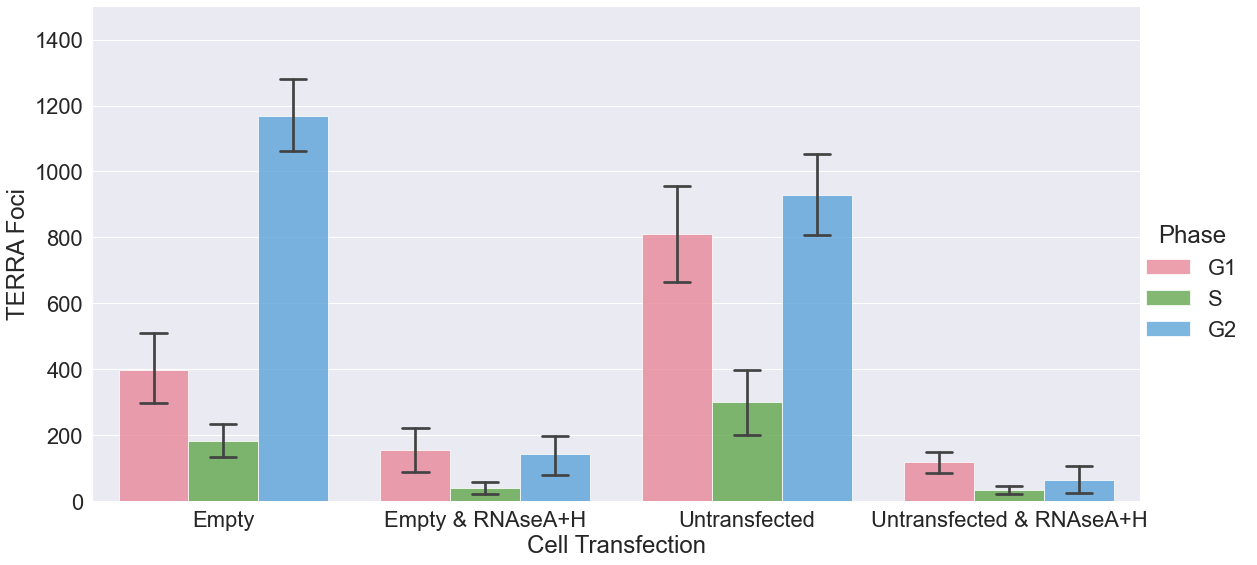

In [45]:
#Show that when looking at TERRA Amount +RNASe reduces TERRA
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2, 
    order=["Empty","Empty & RNAseA+H","Untransfected","Untransfected & RNAseA+H"],  
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "TERRA Foci")
g.legend.set_title("Phase")
#plt.title("Amount of TERRA per Phase")
g.set(ylim=(0,1500))

#plt.savefig(f'g2_EmpvuntranswRNAse.png', dpi=900, bbox_inches='tight')

In [46]:
#Compare Empty vs. Emepty +RNASe
u = stats.f_oneway(g2_df['TERRA Amount'].loc[:14],
               g2_df['TERRA Amount'].loc[15:29],
                  )

#Compare untrans vs. untrans +RNASe 
v =stats.f_oneway(g2_df['TERRA Amount'].loc[90:104],
               g2_df['TERRA Amount'].loc[105:119],
                   )

#empty [:14]
#Empty &RNAse [15:29]
#EN-T [30:44]
#EN-T & RNAseA+H [45:59]
#TRF1 [60:74]
#TRF1 & RNAseA+H [75:89]
#Untransfected[90:104]
#Untrans +Rnase [105:119]
                                 
print(u,'empty\n',v,'Untrans\n')

F_onewayResult(statistic=13.360045653819414, pvalue=0.0010506304153717657) empty
 F_onewayResult(statistic=32.41484431533355, pvalue=4.189138378679088e-06) Untrans



## Extra Stats

### INTER-cell stats

In [47]:
#Tukey between all the means of terra amount forr all cell conditions
g2tukey = pairwise_tukeyhsd(endog=g2_df['TERRA Amount'],
                          groups=g2_df['Cell_condition'],
                          alpha=0.05)

print(g2tukey)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
     group1               group2           meandiff p-adj    lower      upper   reject
--------------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H -432.2667 0.0573  -871.6305    7.0972  False
            EN-T                    Empty      41.0    0.9  -398.3638  480.3638  False
            EN-T         Empty & RNAseA+H -430.1667 0.0597  -869.5305    9.1972  False
            EN-T                     TRF1     214.0 0.7783  -225.3638  653.3638  False
            EN-T          TRF1 & RNAseA+H    -417.3 0.0758  -856.6638   22.0638  False
            EN-T            Untransfected     137.0    0.9  -302.3638  576.3638  False
            EN-T Untransfected & RNAseA+H -469.5667 0.0273  -908.9305  -30.2028   True
 EN-T & RNAseA+H                    Empty  473.2667 0.0253    33.9028  912.6305   True
 EN-T & RNAseA+H         Empty & RNAseA+H  

,Cell Transfection,G1 Cell,S Cell,G2 Cell,G1 TERRA,S TERRA,G2 TERRA
0,Empty,9.0,2.0,64.5,132.0,65.0,1024.5
1,Empty,16.5,10.5,39.5,346.5,245.5,884.5
2,Empty,50.5,3.5,49.0,814.0,76.5,1082.0
3,Empty,21.0,12.0,63.5,437.0,380.5,1330.0
4,Empty,16.0,6.0,70.0,264.0,152.5,1522.0
5,Empty & RNAseA+H,42.0,29.5,4.0,90.0,38.5,6.5


In [49]:
# The rows that correspond to each cell type for .loc

#Empty [:14]
#Empty &RNAse [15:29]
#EN-T [30:44]
#EN-T & RNAseA+H [45:59]
#TRF1 [60:74]
#TRF1 & RNAseA+H [75:89]
#Untransfected[90:104]
#Untrans +Rnase [105:119]


#Compare G1 b/w EN-T and TRF1
EvTG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[30:34],
               g2_df['TERRA Amount'].loc[60:64],
                  )
#Compare S b/w EN-T and TRF1
EvTS =stats.f_oneway(g2_df['TERRA Amount'].loc[35:39],
               g2_df['TERRA Amount'].loc[65:69],
                   )
#Compare G2 b/w EN-T and TRF1
EvTG2 = stats.f_oneway(g2_df['TERRA Amount'].loc[40:44],
               g2_df['TERRA Amount'].loc[70:74],
                                 )
print(EvTG1,'EvTG1\n',EvTS,'EvTS\n',EvTG2,'EvTG2\n')



#Compare G1 b/w Empty and TRF1
emvTG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[0:4],
               g2_df['TERRA Amount'].loc[60:64],
                  )
#Compare S b/w Empty and TRF1
emvTS =stats.f_oneway(g2_df['TERRA Amount'].loc[5:9],
               g2_df['TERRA Amount'].loc[65:69],
                   )
#Compare G2 b/w Empty and TRF1
emvTG2 = stats.f_oneway(g2_df['TERRA Amount'].loc[10:14],
               g2_df['TERRA Amount'].loc[70:74],
                                 )
print(emvTG1,'emvTG1\n',emvTS,'emvS\n',emvTG2,'emvG2\n')



#Compare G1 b/w untransfected and TRF1
unvTG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[90:94],
               g2_df['TERRA Amount'].loc[60:64],
                  )
#Compare S b/w untransfected and TRF1
unvTS =stats.f_oneway(g2_df['TERRA Amount'].loc[95:99],
               g2_df['TERRA Amount'].loc[65:69],
                   )
#Compare G2 b/w untransfected and TRF1
unvTG2 = stats.f_oneway(g2_df['TERRA Amount'].loc[100:104],
               g2_df['TERRA Amount'].loc[70:74],
                                 )
print(unvTG1,'unvTG1\n',unvTS,'unvS\n',unvTG2,'unvG2\n')


#Compare G1 b/w EN-T and Empty
EvemG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[30:34],
               g2_df['TERRA Amount'].loc[0:4],
                  )
#Compare S b/w EN-T and Empty
EvemS =stats.f_oneway(g2_df['TERRA Amount'].loc[35:39],
               g2_df['TERRA Amount'].loc[5:9],
                   )
#Compare G2 b/w EN-T and Empty
EvemG2 = stats.f_oneway(g2_df['TERRA Amount'].loc[40:44],
               g2_df['TERRA Amount'].loc[10:14],
                                 )
print(EvemG1,'EvemG1\n',EvemS,'EvTS\n',EvemG2,'EvemG2\n')



#Compare G1 b/w EN-T and Untransfected
EvemG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[30:34],
               g2_df['TERRA Amount'].loc[90:94],
                  )
#Compare S b/w EN-T and Untransfected
EvemS =stats.f_oneway(g2_df['TERRA Amount'].loc[35:39],
               g2_df['TERRA Amount'].loc[95:99],
                   )
#Compare G2 b/w EN-T and Untransfected
EvemG2 = stats.f_oneway(g2_df['TERRA Amount'].loc[40:44],
               g2_df['TERRA Amount'].loc[100:104],
                                 )
print(EvemG1,'EvemG1\n',EvemS,'EvTS\n',EvemG2,'EvemG2\n')



#Compare G1 b/w Untrannsfected and Empty
unvemG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[90:94],
               g2_df['TERRA Amount'].loc[0:4],
                  )
#Compare S b/w EN-T and Empty
unvemS =stats.f_oneway(g2_df['TERRA Amount'].loc[95:99],
               g2_df['TERRA Amount'].loc[5:9],
                   )
#Compare G2 b/w EN-T and Empty
unvemG2 = stats.f_oneway(g2_df['TERRA Amount'].loc[100:104],
               g2_df['TERRA Amount'].loc[10:14],
                                 )
print(unvemG1,'unvemG1\n',unvemS,'unvTS\n',unvemG2,'unvemG2\n')

F_onewayResult(statistic=0.7854207951618224, pvalue=0.4013429836639654) EvTG1
 F_onewayResult(statistic=0.15396857390740432, pvalue=0.7050184832640027) EvTS
 F_onewayResult(statistic=2.0090560048320407, pvalue=0.19411120243977137) EvTG2

F_onewayResult(statistic=0.00366155893712651, pvalue=0.9532331580627053) emvTG1
 F_onewayResult(statistic=1.3922470262900868, pvalue=0.27192032773492447) emvS
 F_onewayResult(statistic=1.3046524840603497, pvalue=0.2863965644331327) emvG2

F_onewayResult(statistic=4.841751709537716, pvalue=0.05895729770434912) unvTG1
 F_onewayResult(statistic=0.009663668706971646, pvalue=0.92410939333192) unvS
 F_onewayResult(statistic=3.001352204086514, pvalue=0.12143092030649866) unvG2

F_onewayResult(statistic=0.7000714324856009, pvalue=0.4270443516849516) EvemG1
 F_onewayResult(statistic=2.626593367159815, pvalue=0.14374564479334118) EvTS
 F_onewayResult(statistic=0.44157616153155665, pvalue=0.5250499784552034) EvemG2

F_onewayResult(statistic=9.06444666383922, pval

In [50]:
# Tukey between all cells over G1 for cell amount
G1_cell = pairwise_tukeyhsd(endog=g2_tukey_df['G1 Cell'],
                          groups=g2_tukey_df['Cell Transfection'],
                          alpha=0.05)

# Tukey between all cells over S for cell amount
S_cell = pairwise_tukeyhsd(endog=g2_tukey_df['S Cell'],
                          groups=g2_tukey_df['Cell Transfection'],
                          alpha=0.05)

# Tukey between all cells over G2 for cell amount
G2_cell = pairwise_tukeyhsd(endog=g2_tukey_df['G2 Cell'],
                          groups=g2_tukey_df['Cell Transfection'],
                          alpha=0.05)

# Tukey between all cells over G1 for TERRA amount
G1_terra = pairwise_tukeyhsd(endog=g2_tukey_df['G1 TERRA'],
                          groups=g2_tukey_df['Cell Transfection'],
                          alpha=0.05)

# Tukey between all cells over S for TERRA amount
S_terra = pairwise_tukeyhsd(endog=g2_tukey_df['S TERRA'],
                          groups=g2_tukey_df['Cell Transfection'],
                          alpha=0.05)

# Tukey between all cells over G2 for TERRA amount
G2_terra = pairwise_tukeyhsd(endog=g2_tukey_df['G2 TERRA'],
                          groups=g2_tukey_df['Cell Transfection'],
                          alpha=0.05)

print(G1_cell, 'G1_cell\n',
      S_cell, 'S_cell\n',
      G2_cell, 'G2_cell\n',
      G1_terra, 'G1_terra\n',
      S_terra, 'S_terra\n',
      G2_terra, 'G2_terra\n',)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1               group2          meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H      3.5    0.9 -32.4333 39.4333  False
            EN-T                    Empty      6.5    0.9 -29.4333 42.4333  False
            EN-T         Empty & RNAseA+H      8.6    0.9 -27.3333 44.5333  False
            EN-T                     TRF1     -1.8    0.9 -37.7333 34.1333  False
            EN-T          TRF1 & RNAseA+H      6.6    0.9 -29.3333 42.5333  False
            EN-T            Untransfected     24.3 0.3853 -11.6333 60.2333  False
            EN-T Untransfected & RNAseA+H     43.1 0.0101   7.1667 79.0333   True
 EN-T & RNAseA+H                    Empty      3.0    0.9 -32.9333 38.9333  False
 EN-T & RNAseA+H         Empty & RNAseA+H      5.1    0.9 -30.8333 41.0333  False
 EN-T & RNAseA+H

### INTRA-cell stats

In [51]:
#Empty [:14]
#Empty &RNAse [15:29]
#EN-T [30:44]
#EN-T & RNAseA+H [45:59]
#TRF1 [60:74]
#TRF1 & RNAseA+H [75:89]
#Untransfected[90:104]
#Untrans +Rnase [105:119]

#Compare G1 & S EN-T 
EG1vS = stats.f_oneway(g2_df['TERRA Amount'].loc[30:34],
               g2_df['TERRA Amount'].loc[35:39],
                  )
#Compare S & G2 b/w EN-T 
ESvG2 =stats.f_oneway(g2_df['TERRA Amount'].loc[35:39],
               g2_df['TERRA Amount'].loc[40:44],
                   )
#Compare G2 & G1 b/w EN-T 
EG2vG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[40:44],
               g2_df['TERRA Amount'].loc[30:34],
                                 )
print(EG1vS,'EG1vS\n',ESvG2,'ESvG2\n',EG2vG1,'EG2vG1\n')



#Compare G1 & S TRF1
TG1vS = stats.f_oneway(g2_df['TERRA Amount'].loc[60:64],
               g2_df['TERRA Amount'].loc[65:69],
                  )
#Compare S & G2 b/w TRF1 
TSvG2 =stats.f_oneway(g2_df['TERRA Amount'].loc[65:69],
               g2_df['TERRA Amount'].loc[70:74],
                   )
#Compare G2 & G1 b/w TRF1 
TG2vG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[70:74],
               g2_df['TERRA Amount'].loc[60:64],
                                 )
print(TG1vS,'TG1vS\n',TSvG2,'TSvG2\n',TG2vG1,'TG2vG1\n')



#Compare G1 & S Empty
emG1vS = stats.f_oneway(g2_df['TERRA Amount'].loc[:4],
               g2_df['TERRA Amount'].loc[5:9],
                  )
#Compare S & G2 b/w Empty 
emSvG2 =stats.f_oneway(g2_df['TERRA Amount'].loc[5:9],
               g2_df['TERRA Amount'].loc[10:14],
                   )
#Compare G2 & G1 b/w Empty 
emG2vG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[10:14],
               g2_df['TERRA Amount'].loc[:4],
                                 )
print(emG1vS,'emG1vS\n',emSvG2,'emSvG2\n',emG2vG1,'emG2vG1\n')


#Compare G1 & S Untrans
unG1vS = stats.f_oneway(g2_df['TERRA Amount'].loc[90:94],
               g2_df['TERRA Amount'].loc[95:99],
                  )
#Compare S & G2 b/w Untrans 
unSvG2 =stats.f_oneway(g2_df['TERRA Amount'].loc[95:99],
               g2_df['TERRA Amount'].loc[100:104],
                   )
#Compare G2 & G1 b/w Untrans 
unG2vG1 = stats.f_oneway(g2_df['TERRA Amount'].loc[100:104],
               g2_df['TERRA Amount'].loc[90:94],
                                 )
print(unG1vS,'unG1vS\n',unSvG2,'unSvG2\n',unG2vG1,'unG2vG1\n')

F_onewayResult(statistic=0.14694436108276815, pvalue=0.711458466645431) EG1vS
 F_onewayResult(statistic=9.480585718435277, pvalue=0.015138564996451722) ESvG2
 F_onewayResult(statistic=10.778057610677621, pvalue=0.011137884455815877) EG2vG1

F_onewayResult(statistic=0.7388145899419202, pvalue=0.41505368917179414) TG1vS
 F_onewayResult(statistic=13.185915022668668, pvalue=0.006673025170149046) TSvG2
 F_onewayResult(statistic=10.814567232793683, pvalue=0.011045898174463109) TG2vG1

F_onewayResult(statistic=2.7516538185569135, pvalue=0.13573830681647733) emG1vS
 F_onewayResult(statistic=58.928284279473694, pvalue=5.870558733597032e-05) emSvG2
 F_onewayResult(statistic=22.54397854932182, pvalue=0.0014488764940196368) emG2vG1

F_onewayResult(statistic=6.936758867342587, pvalue=0.03000193905916875) unG1vS
 F_onewayResult(statistic=12.22638742440406, pvalue=0.00811914961680559) unSvG2
 F_onewayResult(statistic=0.28987382592475264, pvalue=0.6049537437310788) unG2vG1



In [86]:
#Empty [:14]
#Empty &RNAse [15:29]
#EN-T [30:44]
#EN-T & RNAseA+H [45:59]
#TRF1 [60:74]
#TRF1 & RNAseA+H [75:89]
#Untransfected[90:104]
#Untrans +Rnase [105:119]

#Tukey for the TERRA amounts between cell phases in each cell transfection
#For ENT
intra_ENT_terra_tukey = pairwise_tukeyhsd(endog=g2_df['TERRA Amount'].loc[30:44],
                          groups=g2_df['Phase'].loc[30:44],
                          alpha=0.05)
print(intra_ENT_terra_tukey,'ENT TERRA Amount\n')



#For TRF1
intra_TRF1_terra_tukey = pairwise_tukeyhsd(endog=g2_df['TERRA Amount'].loc[60:74],
                          groups=g2_df['Phase'].loc[60:74],
                          alpha=0.05)
print(intra_TRF1_terra_tukey,'TRF1 TERRA Amount\n')



#For Empty
intra_empty_terra_tukey = pairwise_tukeyhsd(endog=g2_df['TERRA Amount'].loc[:14],
                          groups=g2_df['Phase'].loc[:14],
                          alpha=0.05)
print(intra_empty_terra_tukey,'Empty TERRA Amount\n')


#For untrans
intra_untrans_terra_tukey = pairwise_tukeyhsd(endog=g2_df['TERRA Amount'].loc[90:104],
                          groups=g2_df['Phase'].loc[90:104],
                          alpha=0.05)
print(intra_untrans_terra_tukey,'untrans TERRA Amount\n')

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2 meandiff p-adj   lower      upper   reject
--------------------------------------------------------
    G1     G2    713.6 0.006   220.1266 1207.0734   True
    G1      S     30.3   0.9  -463.1734  523.7734  False
    G2      S   -683.3 0.008 -1176.7734 -189.8266   True
-------------------------------------------------------- ENT

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2 meandiff p-adj    lower      upper   reject
---------------------------------------------------------
    G1     G2   1202.3 0.0049   393.2074 2011.3926   True
    G1      S   -100.8    0.9  -909.8926  708.2926  False
    G2      S  -1303.1 0.0028 -2112.1926 -494.0074   True
--------------------------------------------------------- TRF1

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2 meandiff p-adj    lower      upper   reject
---------------------------------------------------------
    G1    

In [87]:
#Tukey for the Cell amounts between cell phases in each cell transfection
#For ENT
intra_ENT_Cell_tukey = pairwise_tukeyhsd(endog=g2_df['Cell Amount'].loc[30:44],
                          groups=g2_df['Phase'].loc[30:44],
                          alpha=0.05)
print(intra_ENT_Cell_tukey,'ENT Cell Amount\n')



#For TRF1
intra_TRF1_Cell_tukey = pairwise_tukeyhsd(endog=g2_df['Cell Amount'].loc[60:74],
                          groups=g2_df['Phase'].loc[60:74],
                          alpha=0.05)
print(intra_TRF1_Cell_tukey,'TRF1 Cell Amount\n')



#For Empty
intra_empty_Cell_tukey = pairwise_tukeyhsd(endog=g2_df['Cell Amount'].loc[:14],
                          groups=g2_df['Phase'].loc[:14],
                          alpha=0.05)
print(intra_empty_Cell_tukey,'Empty Cell Amount\n')


#For untrans
intra_untrans_Cell_tukey = pairwise_tukeyhsd(endog=g2_df['Cell Amount'].loc[90:104],
                          groups=g2_df['Phase'].loc[90:104],
                          alpha=0.05)
print(intra_untrans_Cell_tukey,'untrans Cell Amount\n')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    G1     G2     38.9  0.001  23.3324  54.4676   True
    G1      S     -3.3 0.8327 -18.8676  12.2676  False
    G2      S    -42.2  0.001 -57.7676 -26.6324   True
------------------------------------------------------ ENT Cell Amount

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
    G1     G2     49.2 0.001  33.7317  64.6683   True
    G1      S     -6.2  0.55 -21.6683   9.2683  False
    G2      S    -55.4 0.001 -70.8683 -39.9317   True
----------------------------------------------------- TRF1 Cell Amount

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    G1     G2     34.7 0.0018  14.279

In [89]:
#Tukey for the Cell % In Phase between cell phases in each cell transfection
#For ENT
intra_ENT_Cell_percent_tukey = pairwise_tukeyhsd(endog=g2_df['Cell % In Phase'].loc[30:44],
                          groups=g2_df['Phase'].loc[30:44],
                          alpha=0.05)
print(intra_ENT_Cell_percent_tukey,'ENT Cell %\n')



#For TRF1
intra_TRF1_Cell_percent_tukey = pairwise_tukeyhsd(endog=g2_df['Cell % In Phase'].loc[60:74],
                          groups=g2_df['Phase'].loc[60:74],
                          alpha=0.05)
print(intra_TRF1_Cell_percent_tukey,'TRF1 Cell %\n')



#For Empty
intra_empty_Cell_percent_tukey = pairwise_tukeyhsd(endog=g2_df['Cell % In Phase'].loc[:14],
                          groups=g2_df['Phase'].loc[:14],
                          alpha=0.05)
print(intra_empty_Cell_percent_tukey,'Empty Cell %\n')


#For untrans
intra_untrans_Cell_percent_tukey = pairwise_tukeyhsd(endog=g2_df['Cell % In Phase'].loc[90:104],
                          groups=g2_df['Phase'].loc[90:104],
                          alpha=0.05)
print(intra_untrans_Cell_percent_tukey,'untrans Cell %\n')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    G1     G2  46.2325  0.001  30.6134  61.8517   True
    G1      S  -3.6789 0.7974 -19.2981  11.9402  False
    G2      S -49.9115  0.001 -65.5306 -34.2923   True
------------------------------------------------------ ENT Cell %

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    G1     G2  57.4946  0.001  47.9506  67.0385   True
    G1      S  -6.9756 0.1675 -16.5195   2.5684  False
    G2      S -64.4701  0.001 -74.0141 -54.9262   True
------------------------------------------------------ TRF1 Cell %

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    G1     G2  41.8754  0.001  21.1752  

## Distributions

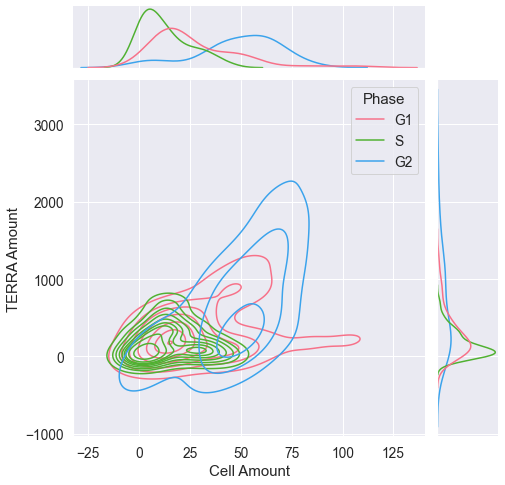

In [53]:
# Show that both the majority percent of cells and percent of TERRA accumulate in G2
ax = sns.set(font_scale=1.25)
g = sns.jointplot(
    data=g2_df,
    x="Cell Amount", y="TERRA Amount", hue="Phase",
    kind="kde",palette="husl",height=7
)

#plt.title('Percent of Cell vs. Percent of TERRA Per Phase', x=-3, y=1.25)

#plt.savefig(f'g2_phase_single_distributions.png', dpi=900, bbox_inches='tight')

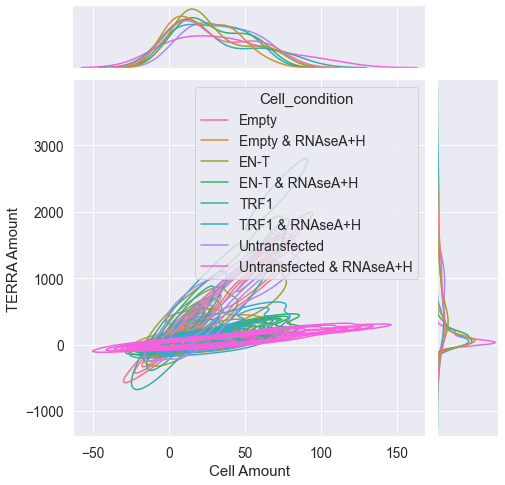

In [54]:
# Show that the accunulation in G2 is independent of the cell condition
ax = sns.set(font_scale=1.25)
g = sns.jointplot(
    data=g2_df,
     x="Cell Amount", y="TERRA Amount", hue="Cell_condition",
    kind="kde",palette="husl", height=7
)

#plt.title('Percent of Cell vs. Percent of TERRA Depending on Cell Condition', x=-3, y=1.25)

#plt.savefig(f'g2_cell_single_distributions.png', dpi=900, bbox_inches='tight')

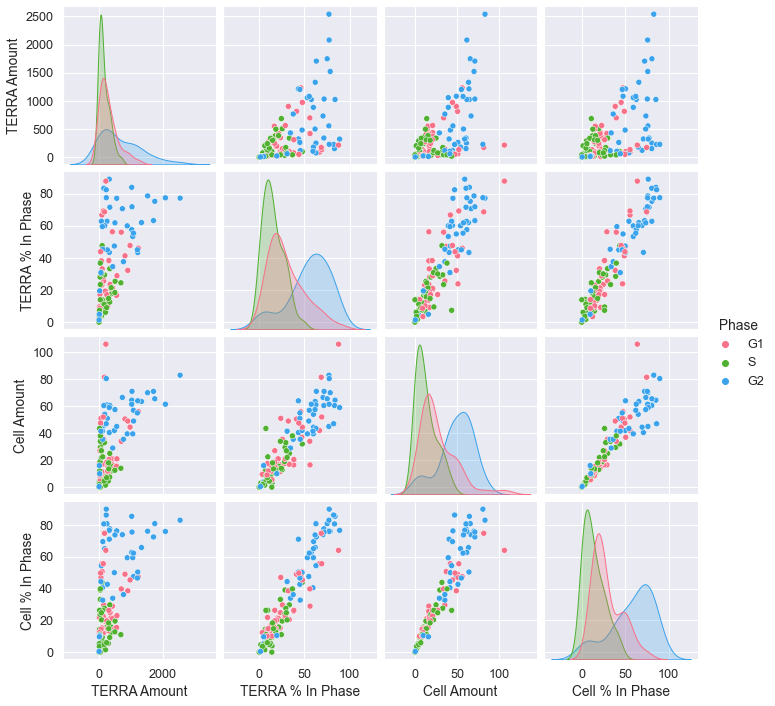

In [55]:
#Seeing the distribution of TERRA and cells through the cell cycle
ax = sns.set(font_scale=1.15)
sns.pairplot(g2_df, hue="Phase", aspect=1, palette="husl")
#plt.title('TERRA and Cell Metrics Distributed Based On Cell Phase', x=-1, y=4.25)

#plt.savefig(f'g2_phase_whole_distributions.png', dpi=900, bbox_inches='tight')

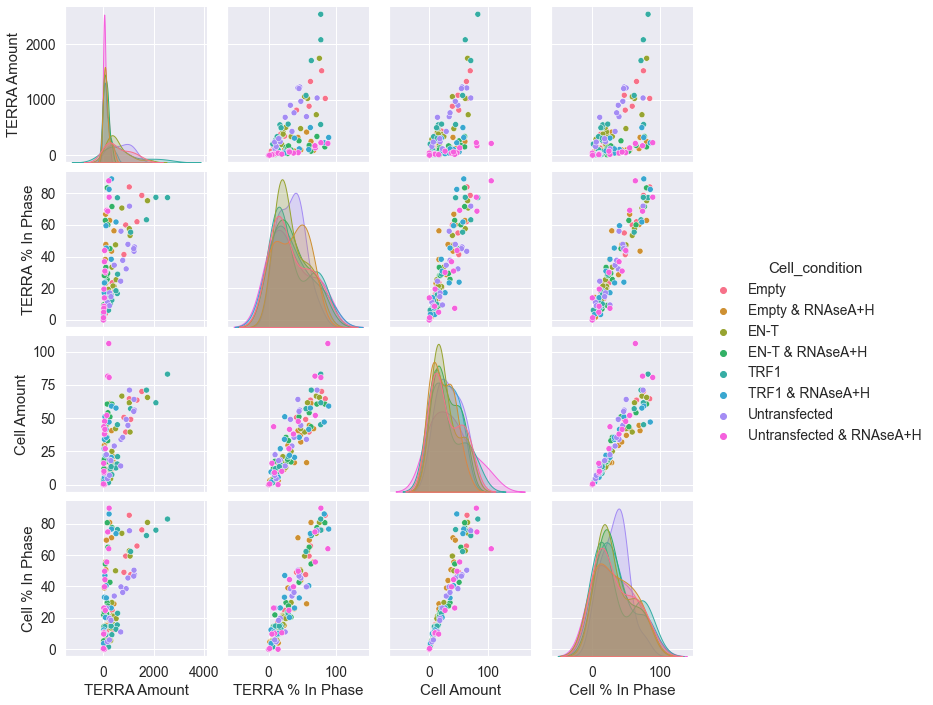

In [56]:
# Seeing if the cell transfection was responsible for the increased TERRA in G2
ax = sns.set(font_scale=1.25)
sns.pairplot(g2_df, hue="Cell_condition", aspect=1, palette="husl")
#plt.title('TERRA and Cell Metrics Distributed Based On Cell Condition',x=-1, y=4.25)

#plt.savefig(f'g2_cell_whole_distributions.png', dpi=900, bbox_inches='tight')

# Supporting

## Figure 1

In [57]:
#Data for FLAG transfection rates
flag_df = pd.read_excel('../Documents/FLAG.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['Cell Transfection','FLAG Foci per Cell'
                               
                              ] 
                         )

flag_df.set_index(['Cell Transfection'])#good way to fix "not in axis issue"
flag_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#flag_df.columns()
flag_df.head()

,Cell Transfection,FLAG Foci per Cell
0,EN-T,11.570093
1,EN-T,12.784091
2,EN-T,20.192982
3,EN-T,27.296296
4,EN-T,20.409836


[None, None, None, None, None, None, None, None]

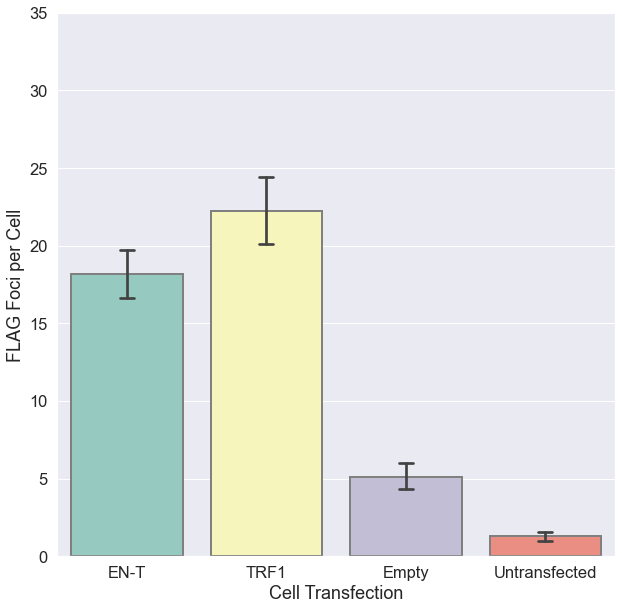

In [58]:
# Bar plot that uses all the values so we can get varience/stats measures
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
ax = sns.barplot(x=flag_df['Cell Transfection'],y='FLAG Foci per Cell',
                 data=flag_df,  palette="Set3", order = ['EN-T' 
                                                         ,#'EN-T & RNAseA+H',
                                                           'TRF1'
                                                         ,#'TRF1 & RNAseA+H',
                                                         'Empty'
                                                         ,#'Empty & RNAseA+H',
                                                            'Untransfected' 
                                                         ,#'Untransfected & RNAseA+H'
                                                        ],
                 capsize=0.1, ci=68,
                )

ax.set(ylim=(0,35), xlabel='Cell Transfection', ylabel = 'FLAG Foci per Cell' )

#plt.title('Mean TERRA Foci/Cell Based On Treatment')
plt.setp(ax.patches, linewidth=2, edgecolor=".5")

#plt.savefig(f'flag.png', dpi=900, bbox_inches='tight')



In [59]:
#ANOVAs
# E v T
Fevt =stats.f_oneway(flag_df['FLAG Foci per Cell'].loc[0:9],
               flag_df['FLAG Foci per Cell'].loc[10:19],
                                 )

# E v em
Fevem = stats.f_oneway(flag_df['FLAG Foci per Cell'].loc[0:9],
               flag_df['FLAG Foci per Cell'].loc[20:29],
                                 )

# E v untrans
Fevun = stats.f_oneway(flag_df['FLAG Foci per Cell'].loc[0:9],
               flag_df['FLAG Foci per Cell'].loc[30:39],
                                 )

# T v em
Ftvem = stats.f_oneway(flag_df['FLAG Foci per Cell'].loc[10:19],
               flag_df['FLAG Foci per Cell'].loc[20:29],
                                 )

# T v untrans
Ftvun = stats.f_oneway(flag_df['FLAG Foci per Cell'].loc[10:19],
               flag_df['FLAG Foci per Cell'].loc[30:39],
                                 )

# em v untrans
Femvun = stats.f_oneway(flag_df['FLAG Foci per Cell'].loc[20:29],
               flag_df['FLAG Foci per Cell'].loc[30:39],
                                 )

print(Fevt,'E v T\n',
      Fevem,'E v em\n',
      Fevun,'E v untrans\n',
      Ftvem,'T v em\n',
      Ftvun,'T v untrans\n',
      Femvun,'em v untrans\n')


F_onewayResult(statistic=1.8385672764351002, pvalue=0.19188710109063792) E v T
 F_onewayResult(statistic=46.88947021403217, pvalue=2.0830728508991975e-06) E v em
 F_onewayResult(statistic=96.92875499488737, pvalue=1.1347631373291408e-08) E v untrans
 F_onewayResult(statistic=42.88515068119321, pvalue=3.736859130144565e-06) T v em
 F_onewayResult(statistic=71.4883526311773, pvalue=1.1047730304801333e-07) T v untrans
 F_onewayResult(statistic=16.23252465658729, pvalue=0.0007873755381036375) em v untrans



In [60]:
# perform Tukey HSD to confirm ANOVA results
flag_tukey = pairwise_tukeyhsd(endog=flag_df['FLAG Foci per Cell'],
                          groups=flag_df['Cell Transfection'],
                          alpha=0.05)

print(flag_tukey)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
     group1               group2          meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H  -8.3059 0.0642 -16.8735   0.2618  False
            EN-T                    Empty -13.0874  0.001 -21.6551  -4.5198   True
            EN-T         Empty & RNAseA+H  -8.4719 0.0548 -17.0396   0.0958  False
            EN-T                     TRF1   4.0438 0.7962  -4.5239  12.6114  False
            EN-T          TRF1 & RNAseA+H  -4.1014  0.784 -12.6691   4.4662  False
            EN-T            Untransfected -16.9052  0.001 -25.4729  -8.3375   True
            EN-T Untransfected & RNAseA+H -17.5305  0.001 -26.0982  -8.9628   True
 EN-T & RNAseA+H                    Empty  -4.7816 0.6399 -13.3493   3.7861  False
 EN-T & RNAseA+H         Empty & RNAseA+H  -0.1661    0.9  -8.7337   8.4016  False
 EN-

## Figure 2

In [61]:
#Data for FLAG transfection rates
h2ax_df = pd.read_excel('../Documents/h2ax.xlsx',
                    sheet_name=4,
                    skiprows = 0,
                    usecols = ['Cell Transfection','Colocolization','Foci per Cell',
                               
                              ] 
                         )

h2ax_df.set_index(['Cell Transfection'])#good way to fix "not in axis issue"
h2ax_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#h2ax_df.columns()
h2ax_df.head()

,Cell Transfection,Colocolization,Foci per Cell
0,EN-T,Telo v. FLAG,39.888889
1,EN-T,Telo v. FLAG,39.923077
2,TRF1,Telo v. FLAG,33.300000
3,TRF1,Telo v. FLAG,34.400000
4,Empty,Telo v. FLAG,0.000000


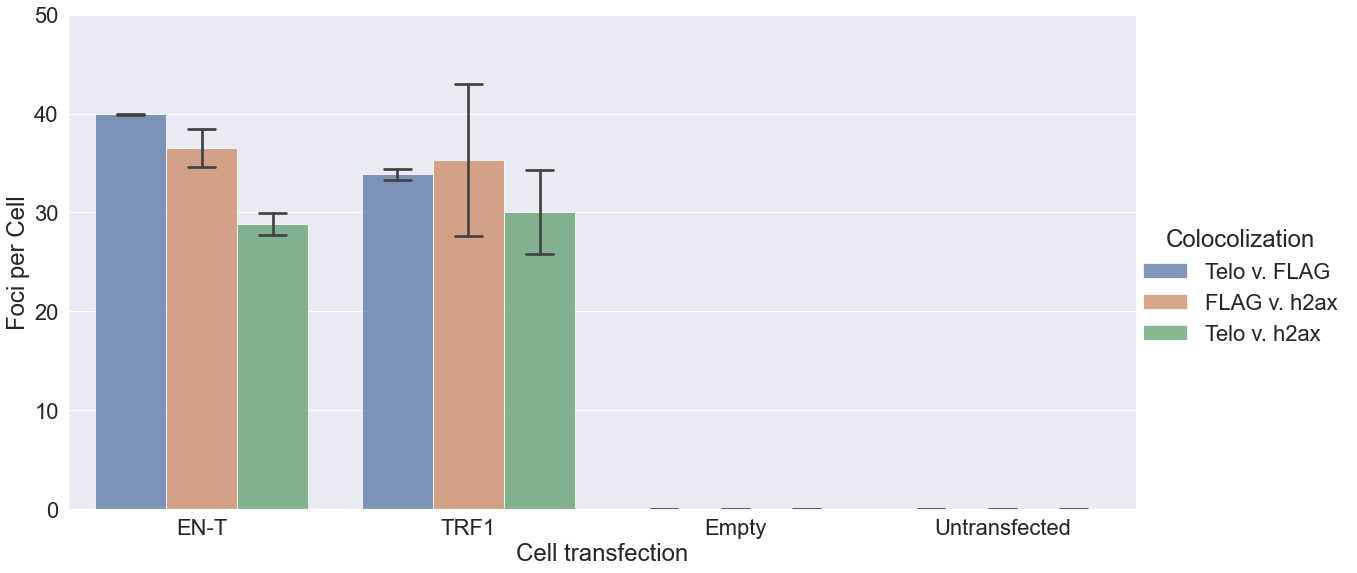

In [62]:
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=h2ax_df, kind="bar",
    x="Cell Transfection", y="Foci per Cell", hue="Colocolization",
    #palette="dark", 
    alpha=.75, height=8, aspect=2,
    order = ['EN-T' 
            ,#'EN-T & RNAseA+H',
            'TRF1'
            ,#'TRF1 & RNAseA+H',
            'Empty'
            ,#'Empty & RNAseA+H',
            'Untransfected' 
            ,#'Untransfected & RNAseA+H'
            ],
                 capsize=0.1, ci=68,
                )

g.despine(left=False)
g.set_axis_labels("Cell transfection", "Foci per Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,50))
#plt.title("Amount of TERRA per Phase")

#plt.savefig(f'h2ax_nornase.png', dpi=900, bbox_inches='tight')

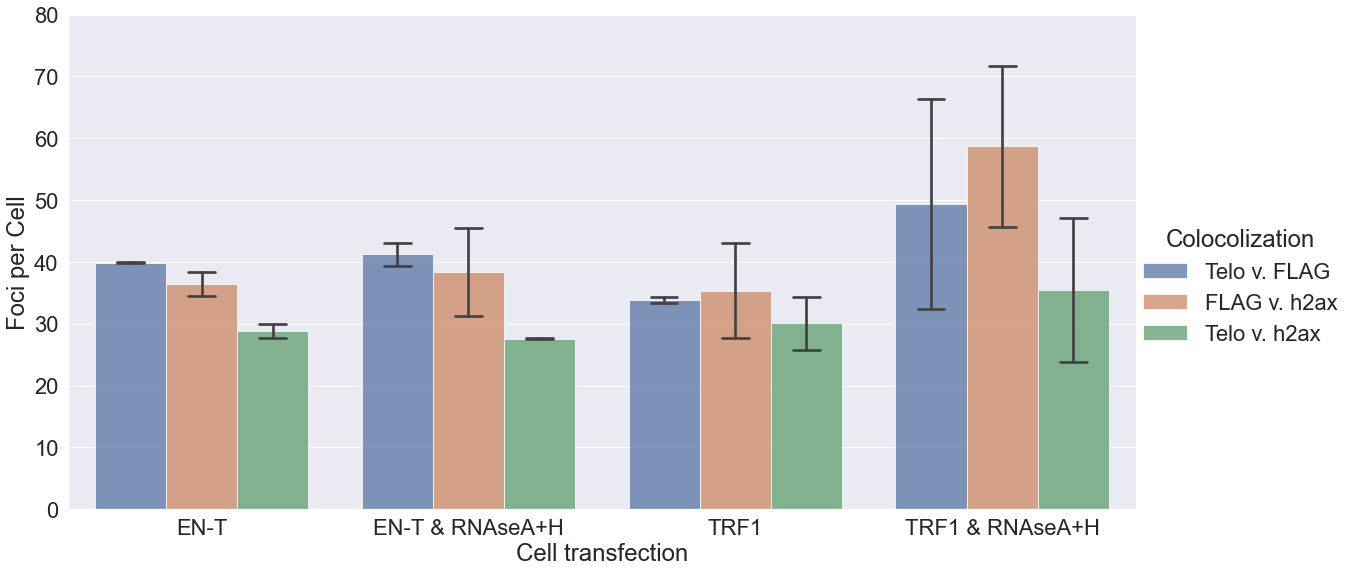

In [63]:
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=h2ax_df, kind="bar",
    x="Cell Transfection", y="Foci per Cell", hue="Colocolization",
    #palette="dark", 
    alpha=.75, height=8, aspect=2,
    order = ['EN-T' 
            ,'EN-T & RNAseA+H',
            'TRF1'
            ,'TRF1 & RNAseA+H',
            #'Empty'
            #,'Empty & RNAseA+H',
            #'Untransfected' 
            #,'Untransfected & RNAseA+H'
            ],
                 capsize=0.1, ci=68,
                )

g.despine(left=False)
g.set_axis_labels("Cell transfection", "Foci per Cell")
g.legend.set_title("Colocolization")
g.set(ylim=(0,80))
#plt.title("Amount of TERRA per Phase")

#plt.savefig(f'h2ax_rnase.png', dpi=900, bbox_inches='tight')

In [64]:
#Data for telo DSB analyis
terra_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=10,
                    skiprows = 0,
                    usecols = ['Cell Transfection', 'TERRA Foci per Cell'
                               
                              ] 
                         )

terra_df.set_index(['Cell Transfection'])#good way to fix "not in axis issue"
terra_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#terra_df.columns()
terra_df.head()

,Cell Transfection,TERRA Foci per Cell
0,Empty,56
1,Empty,63
2,Empty,66
3,Empty,51
4,Empty,44


[None, None, None, None, None, None, None, None]

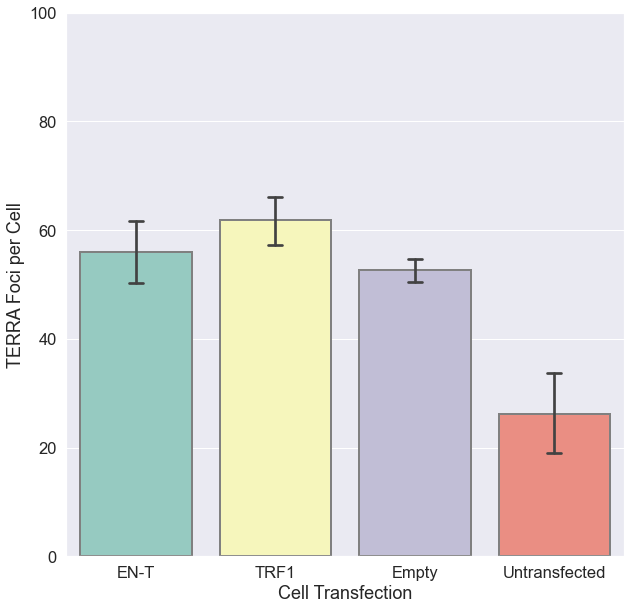

In [65]:
# Bar plot that shos the terra foci for the cell transfections
plt.figure(figsize=(10,10))
ax = sns.set(font_scale=1.5)
ax = sns.barplot(x=terra_df['Cell Transfection'],y='TERRA Foci per Cell',
                 data=terra_df,  palette="Set3", order = ['EN-T' 
                                                         ,#'EN-T & RNAseA+H',
                                                           'TRF1'
                                                         ,#'TRF1 & RNAseA+H',
                                                         'Empty'
                                                         ,#'Empty & RNAseA+H',
                                                            'Untransfected' 
                                                         ,#'Untransfected & RNAseA+H'
                                                        ],
                 capsize=0.1, ci=68,
                )

ax.set(ylim=(0,100), xlabel='Cell Transfection', ylabel = 'TERRA Foci per Cell' )

#plt.title('Mean TERRA Foci/Cell Based On Treatment')
plt.setp(ax.patches, linewidth=2, edgecolor=".5")

#plt.savefig(f'terra.png', dpi=900, bbox_inches='tight')


In [66]:
#ANOVAs
# E v T
Tevt =stats.f_oneway(terra_df['TERRA Foci per Cell'].loc[20:29],
               terra_df['TERRA Foci per Cell'].loc[10:19],
                                 )

# E v em
Tevem = stats.f_oneway(terra_df['TERRA Foci per Cell'].loc[20:29],
               terra_df['TERRA Foci per Cell'].loc[0:9],
                                 )
# E v untrans
Tevun = stats.f_oneway(terra_df['TERRA Foci per Cell'].loc[20:29],
               terra_df['TERRA Foci per Cell'].loc[60:69],
                                 )

# T v em
Ttvem = stats.f_oneway(terra_df['TERRA Foci per Cell'].loc[40:49],
               terra_df['TERRA Foci per Cell'].loc[0:9],
                                 )

# T v untrans
Ttvun = stats.f_oneway(terra_df['TERRA Foci per Cell'].loc[40:49],
               terra_df['TERRA Foci per Cell'].loc[60:69],
                                 )

# em v untrans
Temvun = stats.f_oneway(terra_df['TERRA Foci per Cell'].loc[0:9],
               terra_df['TERRA Foci per Cell'].loc[60:69],
                                 )
print(Tevt,'E v T\n',
      Tevem,'E v em\n',
      Tevun,'E v untrans\n',
      Ttvem,'T v em\n',
      Ttvun,'T v untrans\n',
      Temvun,'em v untrans\n')


F_onewayResult(statistic=14.308865654540247, pvalue=0.0013629140034601853) E v T
 F_onewayResult(statistic=0.27133800282384213, pvalue=0.6087848138795361) E v em
 F_onewayResult(statistic=10.117177381835557, pvalue=0.005176886256623118) E v untrans
 F_onewayResult(statistic=3.2436349392871135, pvalue=0.0884796048233915) T v em
 F_onewayResult(statistic=17.278617157490395, pvalue=0.000592508197646236) T v untrans
 F_onewayResult(statistic=12.067538374076182, pvalue=0.002709607912933867) em v untrans



In [67]:
# perform Tukey HSD to confirm ANOVA results
terra_tukey = pairwise_tukeyhsd(endog=terra_df['TERRA Foci per Cell'],
                          groups=terra_df['Cell Transfection'],
                          alpha=0.05)

print(terra_tukey)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
     group1               group2          meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H    -34.5  0.001 -55.8187 -13.1813   True
            EN-T                    Empty     -3.3    0.9 -24.6187  18.0187  False
            EN-T         Empty & RNAseA+H    -29.8  0.001 -51.1187  -8.4813   True
            EN-T                     TRF1      5.8    0.9 -15.5187  27.1187  False
            EN-T          TRF1 & RNAseA+H    -29.9  0.001 -51.2187  -8.5813   True
            EN-T            Untransfected    -29.9  0.001 -51.2187  -8.5813   True
            EN-T Untransfected & RNAseA+H    -51.9  0.001 -73.2187 -30.5813   True
 EN-T & RNAseA+H                    Empty     31.2  0.001   9.8813  52.5187   True
 EN-T & RNAseA+H         Empty & RNAseA+H      4.7    0.9 -16.6187  26.0187  False
 EN-

In [68]:
#Data for FLAG transfection rates
h2ax_percennt_df = pd.read_excel('../Documents/h2ax.xlsx',
                    sheet_name=5,
                    skiprows = 0,
                    usecols = ['Cell Transfection','Colocolization','Percent Colocolized',
                               
                              ] 
                         )

h2ax_percennt_df.set_index(['Cell Transfection'])#good way to fix "not in axis issue"
h2ax_percennt_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#h2ax_percennt_df.columns()
h2ax_percennt_df.head(50
                     )

,Cell Transfection,Colocolization,Percent Colocolized
0,EN-T,h2ax v. FLAG v. Telo,81.8
1,EN-T,h2ax v. Telo,100.0
2,EN-T,FLAG v. Telo,57.1
3,EN-T,h2ax v. FLAG v. Telo,90.3
4,EN-T,h2ax v. Telo,100.0
5,EN-T,FLAG v. Telo,68.9
6,TRF1,h2ax v. FLAG v. Telo,86.3
7,TRF1,h2ax v. Telo,100.0
8,TRF1,FLAG v. Telo,64.2
9,TRF1,h2ax v. FLAG v. Telo,93.5


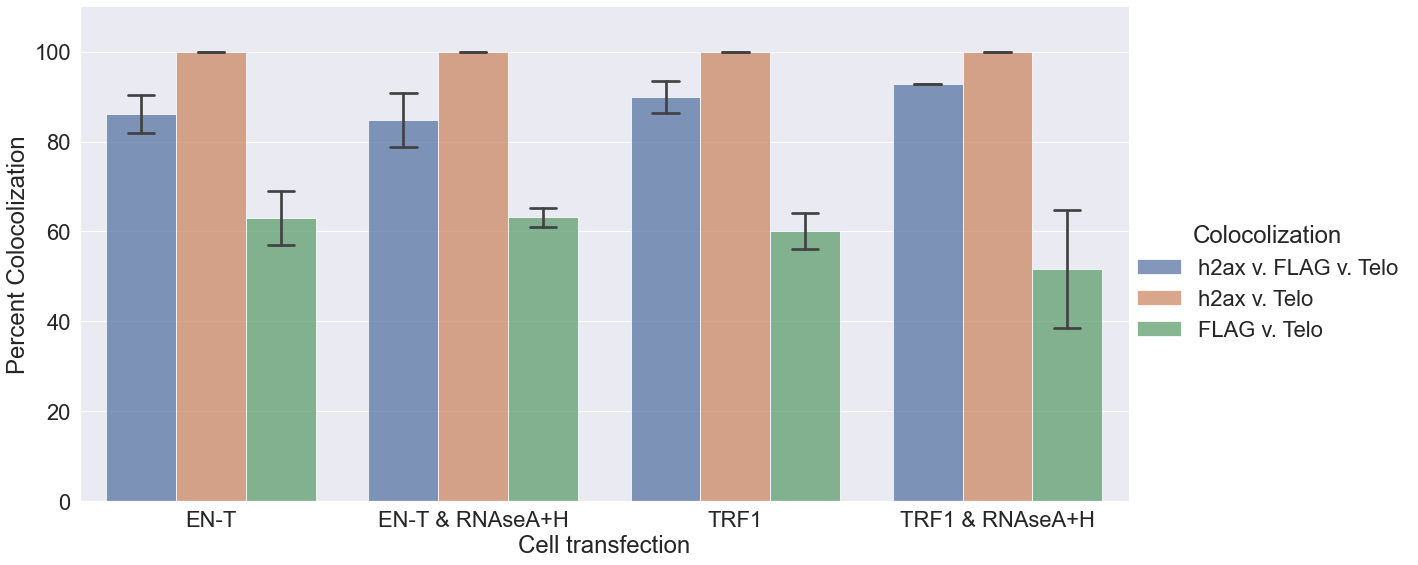

In [69]:
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=h2ax_percennt_df, kind="bar",
    x="Cell Transfection", y="Percent Colocolized", hue="Colocolization",
    #palette="dark", 
    alpha=.75, height=8, aspect=2,
    order = ['EN-T' 
            ,'EN-T & RNAseA+H',
            'TRF1'
            ,'TRF1 & RNAseA+H',
            #'Empty'
            #,'Empty & RNAseA+H',
            #'Untransfected' 
            #,'Untransfected & RNAseA+H'
            ],
                 capsize=0.1, ci=68,
                )

g.despine(left=False)
g.set_axis_labels("Cell transfection", "Percent Colocolization")
g.legend.set_title("Colocolization")
g.set(ylim=(0,110))
#plt.title("Amount of TERRA per Phase")

#plt.savefig(f'h2ax_percent.png', dpi=900, bbox_inches='tight')

### Bound vs. Free TERRA

In [70]:
#Data for telo DSB analyis
freevbound_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=11,
                    skiprows = 0,
                    usecols = ["Cell Transfection", "TERRA Location", "TERRA %", 
                               
                              ] 
                         )

freevbound_df.set_index(['Cell Transfection'])#good way to fix "not in axis issue"
freevbound_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#freevbound_df.columns()
freevbound_df.head()

,Cell Transfection,TERRA Location,TERRA %
0,EN-T,Free,8
1,EN-T,Bound,92
2,TRF1,Free,6
3,TRF1,Bound,94
4,Empty,Free,71


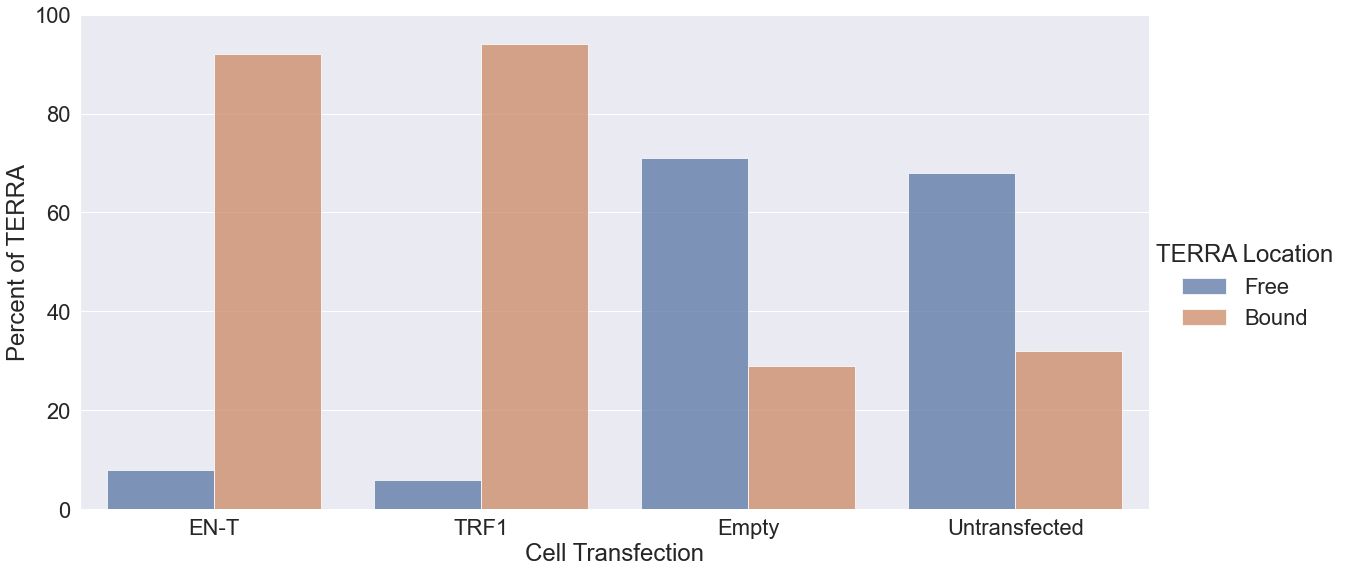

In [71]:
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=freevbound_df, kind="bar",
    x="Cell Transfection", y="TERRA %", hue="TERRA Location",
    capsize=0.1, ci=68, #palette="light",
    alpha=.75, height=8, aspect=2,
    order=["EN-T","TRF1", 'Empty', "Untransfected"],  
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Percent of TERRA")
g.legend.set_title("TERRA Location")
#plt.title("Percent of TERRA per Phase")
g.set(ylim=(0,100))


#plt.savefig(f'freevbound_percent.png', dpi=900, bbox_inches='tight')